# Libraries

In [1]:
project_path = '/home/vrtx26/PycharmProjects/speech-emotion-recognition-system'

In [6]:
import sys
sys.path.insert(1, project_path)   # caution: path[0] is reserved for script path (or '' in REPL)

from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.svm import SVC
import time
import pandas as pd
import numpy as np
from tqdm import tqdm
import data_loader
import model_evaluation
import plotting_utils
import model_training
from sklearn import linear_model
from sklearn import metrics
import copy
from mv_utils import lasso_rank, SVM_eval
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Loading Dataset

In [7]:
X, y, ID = data_loader.load_dataset(X_path='../../data/2023-11-08/feature_mfcc_34_delta_delta_nfft_4096.csv', 
                                    y_path='../../data/2023-11-08/y_labels_feature_34_mfcc_delta_delta_nfft_4096.csv',
                                    ID_path='../../data/2023-11-08/IDs_feature_mfcc_34_delta_delta_nfft_4096.csv') 

data loaded in 0.07700037956237793ms
          0         1         2         3         4         5         6  \
0  0.327805 -0.464719 -0.540320 -0.983787 -1.276392 -0.517576 -0.059207   
1 -0.483202 -0.287426  0.073267 -0.259939 -1.043461  0.220426 -0.243781   
2 -0.982079  1.092156 -0.237941 -0.002997 -0.934974  0.313563  0.708375   
3  0.968642 -1.604765 -0.123183 -0.789169 -1.783557 -0.222486 -0.352760   
4  0.548607 -1.485735 -0.842989 -0.959707 -1.563772 -0.373401 -0.273213   

          7         8         9  ...       296       297       298       299  \
0 -1.325718 -0.865250 -1.400271  ... -0.000500  0.245232  0.467592  0.179897   
1 -0.745799 -0.558315 -0.667095  ...  0.081401 -0.156604  0.054227  1.335473   
2  0.392641 -0.112142 -0.675854  ...  1.159202 -0.281807  0.370446  0.969862   
3 -1.354752 -0.871037 -0.944073  ... -0.582348  1.606737 -1.213523  0.283672   
4 -1.374351 -0.530736 -0.333489  ... -0.312877 -1.016252 -0.713702  0.537837   

        300       301       302

# Backward step selection

In [10]:
def back_step_selection_loso(X,y,feature_ind, ID):
# BACK_STEP_SELECTION Automatic procedure of feature selection

#basic version
   acc_mu_curr = SVM_eval(X,y,feature_ind, ID)
   some_feature_droped = True
   while (some_feature_droped):
      print('NEW ROUND')
      acc_up = -np.ones_like(feature_ind).astype(np.float)
      for i in range(len(feature_ind)):
         cur_inds = np.setdiff1d(feature_ind,feature_ind[i])
         acc_mu = SVM_eval(X,y,cur_inds, ID)                  
         
         if (acc_mu>=acc_mu_curr):
            acc_up[i] = acc_mu-acc_mu_curr
            print(f'Iter #{i}: {acc_mu:.3f} <-> {acc_mu_curr:.3f}')
            
      m_val = np.max(acc_up)
      m_ind = np.argmax(acc_up)
      
      if (m_val>=0):
         print(f'Withdraw feature #{m_ind}, added accracy {m_val}')
         feature_ind = np.setdiff1d(feature_ind,feature_ind[m_ind]);
         some_feature_droped = True       
         # new basic version
         acc_mu_curr = SVM_eval(X,y,feature_ind, ID)
      else:
         acc_final = acc_mu_curr
         some_feature_droped = False

   return acc_final, feature_ind

## Full cycle of feature selection

  0%|                                                                                                                                                                                              | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.815e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
  0%|▉                                                                                                                                                                                     | 1/200 [00:09<33:01,  9.96s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

  8%|█████████████▌                                                                                                                                                                       | 15/200 [02:07<27:30,  8.92s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.814e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
  8%|██████████████▍                                                                                                                                                                      | 16/200 [02:17<27:54,  9.10s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 15%|███████████████████████████▏                                                                                                                                                         | 30/200 [04:29<26:38,  9.40s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.808e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
 16%|████████████████████████████                                                                                                                                                         | 31/200 [04:38<26:24,  9.38s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 22%|████████████████████████████████████████▋                                                                                                                                            | 45/200 [06:51<24:30,  9.49s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.754e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
 23%|█████████████████████████████████████████▋                                                                                                                                           | 46/200 [07:00<24:23,  9.50s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 30%|██████████████████████████████████████████████████████▎                                                                                                                              | 60/200 [09:12<21:59,  9.43s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.365e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
 30%|███████████████████████████████████████████████████████▏                                                                                                                             | 61/200 [09:21<21:50,  9.43s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 38%|███████████████████████████████████████████████████████████████████▉                                                                                                                 | 75/200 [11:30<19:16,  9.26s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.111e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
 38%|████████████████████████████████████████████████████████████████████▊                                                                                                                | 76/200 [11:40<19:23,  9.38s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 45%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 90/200 [13:52<17:17,  9.43s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.112e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
 46%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 91/200 [14:01<17:17,  9.52s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 52%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 105/200 [16:13<15:00,  9.48s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.015e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
 53%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 106/200 [16:23<14:52,  9.49s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 120/200 [18:29<11:48,  8.86s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.731e+01, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 121/200 [18:37<11:33,  8.77s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [21:23<00:00,  6.42s/it]


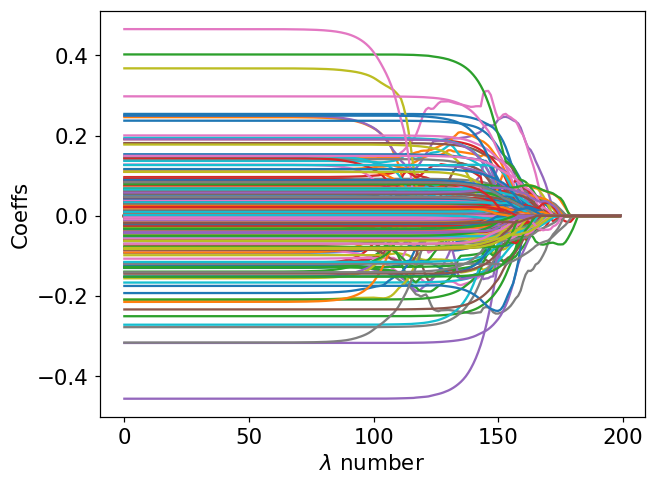

  0%|▌                                                                                                                                                                                     | 1/302 [00:00<04:27,  1.12it/s]

Iter =  1  AUC = 0.6681


  1%|█▊                                                                                                                                                                                    | 3/302 [00:02<04:49,  1.03it/s]

Iter =  3  AUC = 0.6797


  1%|██▍                                                                                                                                                                                   | 4/302 [00:04<04:57,  1.00it/s]

Iter =  4  AUC = 0.6899


  2%|███                                                                                                                                                                                   | 5/302 [00:04<04:49,  1.03it/s]

Iter =  5  AUC = 0.7055


  2%|███▌                                                                                                                                                                                  | 6/302 [00:07<07:01,  1.43s/it]

Iter =  6  AUC = 0.7151


  3%|█████▉                                                                                                                                                                               | 10/302 [00:13<07:28,  1.54s/it]

Iter =  10  AUC = 0.7222


  4%|███████▊                                                                                                                                                                             | 13/302 [00:16<05:45,  1.20s/it]

Iter =  13  AUC = 0.7368


  5%|████████▍                                                                                                                                                                            | 14/302 [00:17<05:50,  1.22s/it]

Iter =  14  AUC = 0.7418


  6%|██████████▏                                                                                                                                                                          | 17/302 [00:20<04:59,  1.05s/it]

Iter =  17  AUC = 0.7434


  9%|████████████████▏                                                                                                                                                                    | 27/302 [00:31<05:24,  1.18s/it]

Iter =  27  AUC = 0.7438


  9%|████████████████▊                                                                                                                                                                    | 28/302 [00:33<05:30,  1.21s/it]

Iter =  28  AUC = 0.7510


 10%|█████████████████▉                                                                                                                                                                   | 30/302 [00:35<05:46,  1.27s/it]

Iter =  30  AUC = 0.7512


 10%|██████████████████▌                                                                                                                                                                  | 31/302 [00:37<05:51,  1.30s/it]

Iter =  31  AUC = 0.7618


 12%|██████████████████████▏                                                                                                                                                              | 37/302 [00:44<05:17,  1.20s/it]

Iter =  37  AUC = 0.7843


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 302/302 [10:08<00:00,  2.02s/it]


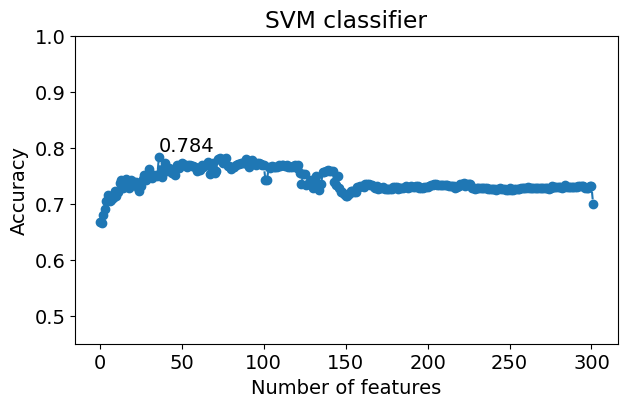

auc_best = 0.78425481
best auc (SVM) =  0.7842548076923077 Number of features =  36
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #6: 0.786 <-> 0.784
Withdraw feature #6, added accracy 0.0014022435897436125
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #11: 0.786 <-> 0.786
Iter #12: 0.786 <-> 0.786
Iter #27: 0.788 <-> 0.786
Withdraw feature #27, added accracy 0.00220352564102555
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #8: 0.789 <-> 0.788
Iter #16: 0.789 <-> 0.788
Withdraw feature #16, added accracy 0.0012019230769231282
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #11: 0.790 <-> 0.789
Iter #12: 0.790 <-> 0.789
Iter #27: 0.789 <-> 0.789
Withdraw feature #11, added accracy 0.0008012820512820484
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #19: 0.792 <-> 0.790
Withdraw feature #19, added accracy 0.0020032051282051766
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)
 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.03it/s]

UAR = 0.303


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.43it/s]

UAR = 0.303


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.92it/s]

UAR = 0.301


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.12it/s]

UAR = 0.312


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.70it/s]

UAR = 0.319


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 20.49it/s]

UAR = 0.323


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.32it/s]

UAR = 0.333


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.11it/s]

UAR = 0.343


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.79it/s]

UAR = 0.352


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.91it/s]

UAR = 0.345


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 21.53it/s]

UAR = 0.351


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 21.01it/s]

UAR = 0.352


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 21.12it/s]

UAR = 0.359


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 21.98it/s]

UAR = 0.360


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 22.19it/s]

UAR = 0.355


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 22.31it/s]

UAR = 0.361


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 22.85it/s]

UAR = 0.357


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 23.07it/s]

UAR = 0.352


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 23.37it/s]

UAR = 0.366


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 24.83it/s]

UAR = 0.368


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 23.36it/s]

UAR = 0.367


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 24.23it/s]

UAR = 0.367


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 22.23it/s]

UAR = 0.364


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 22.24it/s]

UAR = 0.360


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 24.20it/s]

UAR = 0.367


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 23.85it/s]

UAR = 0.365


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 22.42it/s]

UAR = 0.370


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 22.37it/s]

UAR = 0.365


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 21.52it/s]

UAR = 0.363


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.96it/s]

UAR = 0.360


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.63it/s]

UAR = 0.363


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.99it/s]

UAR = 0.362


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.36it/s]

UAR = 0.369


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 14.80it/s]

UAR = 0.370


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 13.87it/s]

UAR = 0.369


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 11.84it/s]

UAR = 0.365


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.55it/s]

UAR = 0.365


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  7.02it/s]

UAR = 0.366


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  7.51it/s]

UAR = 0.368


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


UAR = 0.365


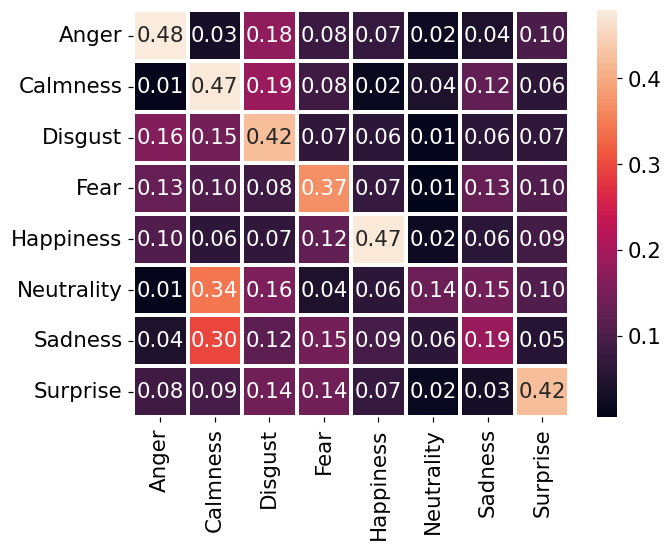

Saving confusion matrix with name:  confusion_matrix_SVM_happy.jpg


  0%|                                                                                                                                                                                              | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.197e+02, tolerance: 3.584e-02
  model = cd_fast.enet_coordinate_descent(
  0%|▉                                                                                                                                                                                     | 1/200 [00:07<24:19,  7.33s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

  8%|█████████████▌                                                                                                                                                                       | 15/200 [02:11<29:32,  9.58s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.197e+02, tolerance: 3.584e-02
  model = cd_fast.enet_coordinate_descent(
  8%|██████████████▍                                                                                                                                                                      | 16/200 [02:20<28:52,  9.41s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 15%|███████████████████████████▏                                                                                                                                                         | 30/200 [04:31<27:04,  9.56s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.195e+02, tolerance: 3.584e-02
  model = cd_fast.enet_coordinate_descent(
 16%|████████████████████████████                                                                                                                                                         | 31/200 [04:41<26:35,  9.44s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 22%|████████████████████████████████████████▋                                                                                                                                            | 45/200 [06:51<23:27,  9.08s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.179e+02, tolerance: 3.584e-02
  model = cd_fast.enet_coordinate_descent(
 23%|█████████████████████████████████████████▋                                                                                                                                           | 46/200 [07:00<23:20,  9.10s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 30%|██████████████████████████████████████████████████████▎                                                                                                                              | 60/200 [09:05<20:45,  8.90s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.043e+02, tolerance: 3.584e-02
  model = cd_fast.enet_coordinate_descent(
 30%|███████████████████████████████████████████████████████▏                                                                                                                             | 61/200 [09:14<20:47,  8.98s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 38%|███████████████████████████████████████████████████████████████████▉                                                                                                                 | 75/200 [11:30<22:18, 10.71s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.779e+01, tolerance: 3.584e-02
  model = cd_fast.enet_coordinate_descent(
 38%|████████████████████████████████████████████████████████████████████▊                                                                                                                | 76/200 [11:42<22:39, 10.96s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 45%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 90/200 [13:58<17:48,  9.72s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.045e+01, tolerance: 3.584e-02
  model = cd_fast.enet_coordinate_descent(
 46%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 91/200 [14:10<18:52, 10.39s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 52%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 105/200 [16:24<14:40,  9.26s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.862e+01, tolerance: 3.584e-02
  model = cd_fast.enet_coordinate_descent(
 53%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 106/200 [16:32<14:15,  9.11s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 120/200 [18:39<11:53,  8.92s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.803e+01, tolerance: 3.584e-02
  model = cd_fast.enet_coordinate_descent(
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 121/200 [18:47<11:42,  8.89s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

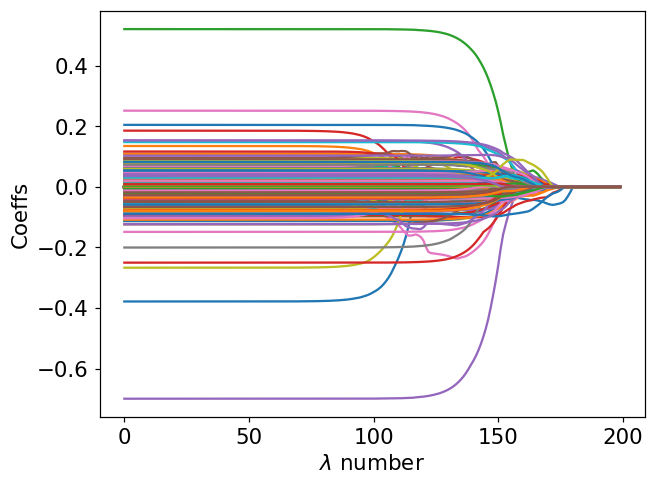

  0%|▌                                                                                                                                                                                     | 1/306 [00:00<04:03,  1.25it/s]

Iter =  1  AUC = 0.7608


  1%|█▊                                                                                                                                                                                    | 3/306 [00:02<04:01,  1.25it/s]

Iter =  3  AUC = 0.7690


  1%|██▍                                                                                                                                                                                   | 4/306 [00:03<03:55,  1.28it/s]

Iter =  4  AUC = 0.7954


  2%|██▉                                                                                                                                                                                   | 5/306 [00:03<03:48,  1.32it/s]

Iter =  5  AUC = 0.8021


  6%|██████████                                                                                                                                                                           | 17/306 [00:13<03:31,  1.37it/s]

Iter =  17  AUC = 0.8155


  6%|███████████▏                                                                                                                                                                         | 19/306 [00:14<03:28,  1.38it/s]

Iter =  19  AUC = 0.8281


  8%|█████████████▌                                                                                                                                                                       | 23/306 [00:17<03:37,  1.30it/s]

Iter =  23  AUC = 0.8419


  8%|███████████████▍                                                                                                                                                                     | 26/306 [00:19<03:28,  1.35it/s]

Iter =  26  AUC = 0.8504


  9%|███████████████▉                                                                                                                                                                     | 27/306 [00:20<03:22,  1.38it/s]

Iter =  27  AUC = 0.8549


 11%|███████████████████▌                                                                                                                                                                 | 33/306 [00:24<03:12,  1.41it/s]

Iter =  33  AUC = 0.8724


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 306/306 [07:08<00:00,  1.40s/it]


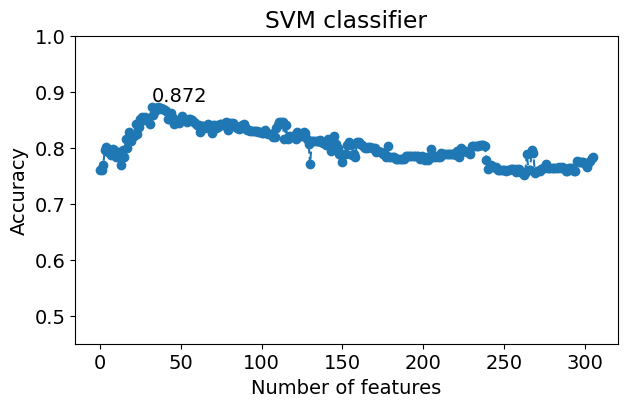

auc_best = 0.87239583
best auc (SVM) =  0.8723958333333333 Number of features =  32
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #6: 0.873 <-> 0.872
Iter #7: 0.873 <-> 0.872
Iter #18: 0.872 <-> 0.872
Iter #25: 0.873 <-> 0.872
Iter #26: 0.874 <-> 0.872
Iter #30: 0.873 <-> 0.872
Withdraw feature #26, added accracy 0.0018601190476190688
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #0: 0.876 <-> 0.874
Iter #3: 0.875 <-> 0.874
Iter #11: 0.879 <-> 0.874
Withdraw feature #11, added accracy 0.0044642857142858094
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #0: 0.884 <-> 0.879
Iter #5: 0.880 <-> 0.879
Iter #29: 0.879 <-> 0.879
Withdraw feature #0, added accracy 0.004836309523809534
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #2: 0.884 <-> 0.884
Iter #12: 0.885 <-> 0.884
Iter #26: 0.884 <-> 0.884
Withdraw feature #12, added accracy 0.0011160714285713969
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #2: 0.885 <-> 0.885
Iter #25: 0.885 <-> 0.885
Withdraw feature #2, added accracy 0.00037202380952372494
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #11: 0.889 <-> 0.885
Iter #24: 0.885 <-> 0.885
Withdraw feature #11, added accracy 0.0040922619047619735
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #22: 0.889 <-> 0.889
Iter #23: 0.890 <-> 0.889
Withdraw feature #23, added accracy 0.00037202380952383596
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #22: 0.890 <-> 0.890
Withdraw feature #22, added accracy 0.0
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)
 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.02it/s]

UAR = 0.277


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.51it/s]

UAR = 0.277


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.50it/s]

UAR = 0.277


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.51it/s]

UAR = 0.277


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.56it/s]

UAR = 0.283


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.74it/s]

UAR = 0.289


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.80it/s]

UAR = 0.298


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.93it/s]

UAR = 0.292


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 14.90it/s]

UAR = 0.306


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.01it/s]

UAR = 0.316


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.48it/s]

UAR = 0.324


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.51it/s]

UAR = 0.326


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.23it/s]

UAR = 0.329


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.40it/s]

UAR = 0.338


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.53it/s]

UAR = 0.338


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.33it/s]

UAR = 0.334


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.27it/s]

UAR = 0.341


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.33it/s]

UAR = 0.347


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.57it/s]

UAR = 0.356


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 20.39it/s]

UAR = 0.361


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 20.56it/s]

UAR = 0.369


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 20.58it/s]

UAR = 0.374


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.83it/s]

UAR = 0.367


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 20.64it/s]

UAR = 0.370


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 21.35it/s]

UAR = 0.367


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.46it/s]

UAR = 0.370


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.35it/s]

UAR = 0.367


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.79it/s]

UAR = 0.370


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.62it/s]

UAR = 0.374


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.29it/s]

UAR = 0.374


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.47it/s]

UAR = 0.373


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.03it/s]

UAR = 0.366


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 14.90it/s]

UAR = 0.370


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 13.95it/s]

UAR = 0.365


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 11.96it/s]

UAR = 0.362


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 11.20it/s]

UAR = 0.370


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 10.74it/s]

UAR = 0.367


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.02it/s]

UAR = 0.369


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  7.30it/s]

UAR = 0.369


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


UAR = 0.371


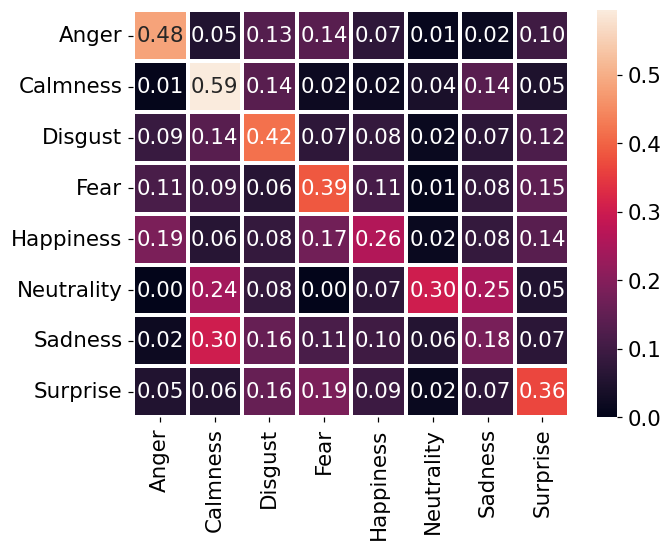

Saving confusion matrix with name:  confusion_matrix_SVM_neutral.jpg


  0%|                                                                                                                                                                                              | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.008e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
  0%|▉                                                                                                                                                                                     | 1/200 [00:08<28:36,  8.62s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

  8%|█████████████▌                                                                                                                                                                       | 15/200 [02:29<31:44, 10.30s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.007e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
  8%|██████████████▍                                                                                                                                                                      | 16/200 [02:39<31:22, 10.23s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 15%|███████████████████████████▏                                                                                                                                                         | 30/200 [05:01<28:56, 10.21s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.000e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
 16%|████████████████████████████                                                                                                                                                         | 31/200 [05:11<28:20, 10.07s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 22%|████████████████████████████████████████▋                                                                                                                                            | 45/200 [07:37<28:46, 11.14s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.936e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
 23%|█████████████████████████████████████████▋                                                                                                                                           | 46/200 [07:47<27:41, 10.79s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 30%|██████████████████████████████████████████████████████▎                                                                                                                              | 60/200 [10:41<25:42, 11.02s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.349e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
 30%|███████████████████████████████████████████████████████▏                                                                                                                             | 61/200 [10:52<25:20, 10.94s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 38%|███████████████████████████████████████████████████████████████████▉                                                                                                                 | 75/200 [13:16<20:00,  9.61s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.259e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
 38%|████████████████████████████████████████████████████████████████████▊                                                                                                                | 76/200 [13:27<20:25,  9.88s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 45%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 90/200 [15:49<19:13, 10.49s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.306e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
 46%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 91/200 [15:58<18:45, 10.33s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 52%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 105/200 [18:21<15:49,  9.99s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.421e+01, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
 53%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 106/200 [18:31<15:44, 10.05s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 120/200 [20:37<10:59,  8.24s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.042e+00, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 121/200 [20:45<10:47,  8.20s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

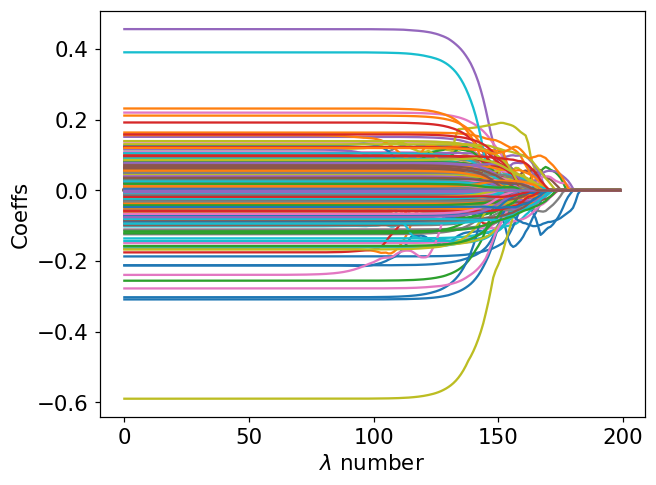

  0%|▌                                                                                                                                                                                     | 1/306 [00:00<04:32,  1.12it/s]

Iter =  1  AUC = 0.6554


  1%|█▏                                                                                                                                                                                    | 2/306 [00:01<04:31,  1.12it/s]

Iter =  2  AUC = 0.6558


  1%|█▊                                                                                                                                                                                    | 3/306 [00:02<04:35,  1.10it/s]

Iter =  3  AUC = 0.6649


  1%|██▍                                                                                                                                                                                   | 4/306 [00:03<04:34,  1.10it/s]

Iter =  4  AUC = 0.6979


  2%|██▉                                                                                                                                                                                   | 5/306 [00:04<04:40,  1.07it/s]

Iter =  5  AUC = 0.7143


  2%|███▌                                                                                                                                                                                  | 6/306 [00:05<04:41,  1.06it/s]

Iter =  6  AUC = 0.7163


  3%|████▊                                                                                                                                                                                 | 8/306 [00:07<04:47,  1.04it/s]

Iter =  8  AUC = 0.7181


  3%|█████▎                                                                                                                                                                                | 9/306 [00:08<04:40,  1.06it/s]

Iter =  9  AUC = 0.7282


  4%|██████▌                                                                                                                                                                              | 11/306 [00:10<04:25,  1.11it/s]

Iter =  11  AUC = 0.7352


  4%|███████▋                                                                                                                                                                             | 13/306 [00:11<04:25,  1.10it/s]

Iter =  13  AUC = 0.7436


  5%|████████▊                                                                                                                                                                            | 15/306 [00:13<04:28,  1.08it/s]

Iter =  15  AUC = 0.7500


  5%|█████████▍                                                                                                                                                                           | 16/306 [00:14<04:22,  1.10it/s]

Iter =  16  AUC = 0.7520


 12%|█████████████████████▉                                                                                                                                                               | 37/306 [00:43<05:46,  1.29s/it]

Iter =  37  AUC = 0.7524


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 306/306 [14:56<00:00,  2.93s/it]


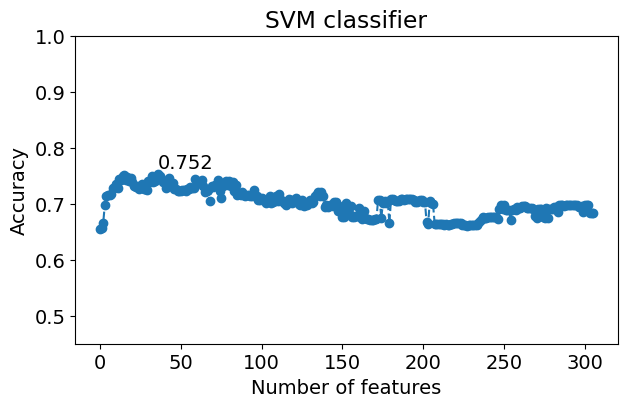

auc_best = 0.75240385
best auc (SVM) =  0.7524038461538461 Number of features =  36
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #2: 0.753 <-> 0.752
Iter #10: 0.754 <-> 0.752
Iter #11: 0.755 <-> 0.752
Iter #13: 0.754 <-> 0.752
Iter #16: 0.758 <-> 0.752
Iter #19: 0.757 <-> 0.752
Iter #20: 0.759 <-> 0.752
Iter #22: 0.757 <-> 0.752
Iter #23: 0.770 <-> 0.752
Iter #26: 0.753 <-> 0.752
Iter #32: 0.753 <-> 0.752
Withdraw feature #23, added accracy 0.01782852564102566
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #2: 0.771 <-> 0.770
Iter #19: 0.776 <-> 0.770
Iter #20: 0.771 <-> 0.770
Iter #31: 0.774 <-> 0.770
Withdraw feature #19, added accracy 0.006209935897435903
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)
 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.69it/s]

UAR = 0.293


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.77it/s]

UAR = 0.292


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.89it/s]

UAR = 0.297


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.25it/s]

UAR = 0.308


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.08it/s]

UAR = 0.309


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.94it/s]

UAR = 0.324


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.87it/s]

UAR = 0.334


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.92it/s]

UAR = 0.341


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.97it/s]

UAR = 0.352


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 20.46it/s]

UAR = 0.351


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.07it/s]

UAR = 0.357


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.60it/s]

UAR = 0.367


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 21.67it/s]

UAR = 0.368


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 21.70it/s]

UAR = 0.368


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 22.27it/s]

UAR = 0.378


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 21.58it/s]

UAR = 0.378


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 21.52it/s]

UAR = 0.375


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 23.20it/s]

UAR = 0.376


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 22.13it/s]

UAR = 0.372


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 22.28it/s]

UAR = 0.368


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 22.13it/s]

UAR = 0.368


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 21.51it/s]

UAR = 0.373


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 23.30it/s]

UAR = 0.374


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 21.86it/s]

UAR = 0.377


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.69it/s]

UAR = 0.378


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 22.56it/s]

UAR = 0.374


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 22.00it/s]

UAR = 0.369


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.18it/s]

UAR = 0.374


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.75it/s]

UAR = 0.373


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.79it/s]

UAR = 0.376


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.48it/s]

UAR = 0.376


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.73it/s]

UAR = 0.369


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 14.79it/s]

UAR = 0.363


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 14.17it/s]

UAR = 0.368


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 13.14it/s]

UAR = 0.362


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 11.43it/s]

UAR = 0.357


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  8.51it/s]

UAR = 0.359


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  7.38it/s]

UAR = 0.359


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  5.76it/s]

UAR = 0.360


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


UAR = 0.361


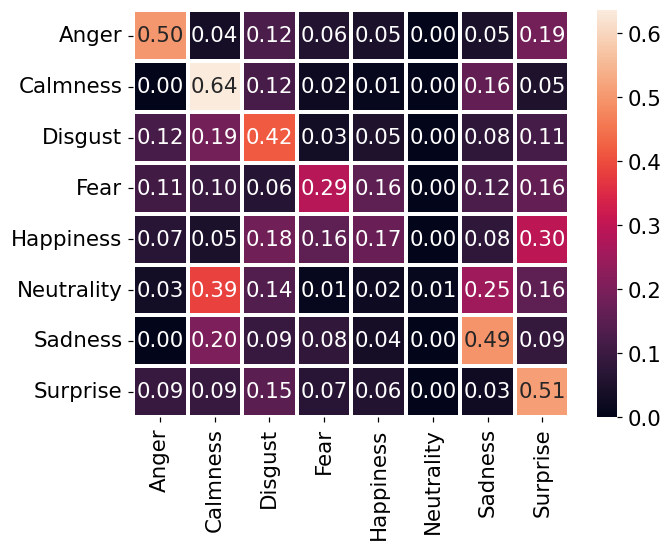

  0%|                                                                                                                                                                                              | 0/200 [00:00<?, ?it/s]

Saving confusion matrix with name:  confusion_matrix_SVM_sad.jpg


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.469e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
  0%|▉                                                                                                                                                                                     | 1/200 [00:09<32:04,  9.67s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.469e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
  1%|█▊                                                                              

  8%|█████████████▌                                                                                                                                                                       | 15/200 [02:20<29:35,  9.59s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.469e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
  8%|██████████████▍                                                                                                                                                                      | 16/200 [02:30<29:15,  9.54s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 15%|███████████████████████████▏                                                                                                                                                         | 30/200 [05:21<34:37, 12.22s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.465e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
 16%|████████████████████████████                                                                                                                                                         | 31/200 [05:30<31:23, 11.14s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 22%|████████████████████████████████████████▋                                                                                                                                            | 45/200 [07:39<23:12,  8.98s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.434e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
 23%|█████████████████████████████████████████▋                                                                                                                                           | 46/200 [07:48<23:07,  9.01s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 30%|██████████████████████████████████████████████████████▎                                                                                                                              | 60/200 [09:59<22:55,  9.83s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.184e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
 30%|███████████████████████████████████████████████████████▏                                                                                                                             | 61/200 [10:07<21:50,  9.43s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 38%|███████████████████████████████████████████████████████████████████▉                                                                                                                 | 75/200 [12:16<19:33,  9.39s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.575e+01, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
 38%|████████████████████████████████████████████████████████████████████▊                                                                                                                | 76/200 [12:25<19:22,  9.37s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 45%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 90/200 [14:34<16:18,  8.89s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.015e+01, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
 46%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 91/200 [14:43<16:09,  8.89s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 52%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 105/200 [16:38<12:37,  7.97s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.114e+01, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
 53%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 106/200 [16:46<12:34,  8.02s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 120/200 [19:09<13:24, 10.06s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.999e-01, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 121/200 [19:16<12:18,  9.34s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

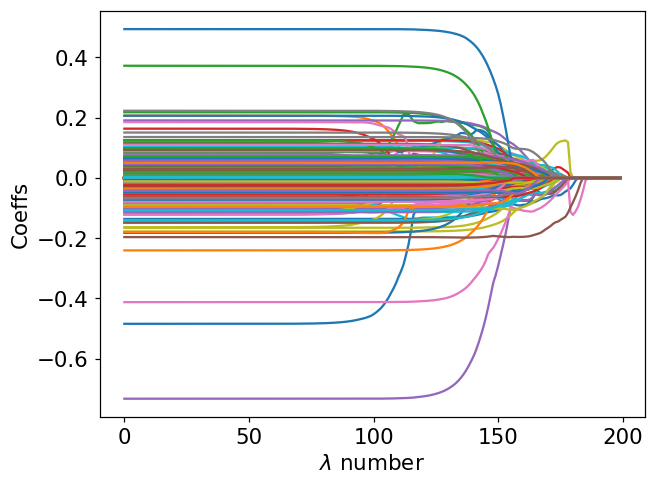

  0%|▌                                                                                                                                                                                     | 1/306 [00:00<03:20,  1.52it/s]

Iter =  1  AUC = 0.7931


  1%|█▏                                                                                                                                                                                    | 2/306 [00:01<03:27,  1.47it/s]

Iter =  2  AUC = 0.7939


  2%|██▉                                                                                                                                                                                   | 5/306 [00:03<03:47,  1.32it/s]

Iter =  5  AUC = 0.8151


  2%|███▌                                                                                                                                                                                  | 6/306 [00:04<03:51,  1.29it/s]

Iter =  6  AUC = 0.8193


  2%|████▏                                                                                                                                                                                 | 7/306 [00:05<03:53,  1.28it/s]

Iter =  7  AUC = 0.8229


  3%|████▊                                                                                                                                                                                 | 8/306 [00:06<03:55,  1.27it/s]

Iter =  8  AUC = 0.8235


  3%|█████▎                                                                                                                                                                                | 9/306 [00:06<03:55,  1.26it/s]

Iter =  9  AUC = 0.8243


  6%|██████████                                                                                                                                                                           | 17/306 [00:14<04:17,  1.12it/s]

Iter =  17  AUC = 0.8331


  6%|███████████▏                                                                                                                                                                         | 19/306 [00:16<05:01,  1.05s/it]

Iter =  19  AUC = 0.8355


  7%|███████████▊                                                                                                                                                                         | 20/306 [00:17<05:02,  1.06s/it]

Iter =  20  AUC = 0.8371


  7%|████████████▍                                                                                                                                                                        | 21/306 [00:18<04:44,  1.00it/s]

Iter =  21  AUC = 0.8375


  7%|█████████████                                                                                                                                                                        | 22/306 [00:19<04:27,  1.06it/s]

Iter =  22  AUC = 0.8379


  8%|█████████████▌                                                                                                                                                                       | 23/306 [00:20<04:11,  1.13it/s]

Iter =  23  AUC = 0.8454


 10%|██████████████████▎                                                                                                                                                                  | 31/306 [00:27<04:35,  1.00s/it]

Iter =  31  AUC = 0.8524


 10%|██████████████████▉                                                                                                                                                                  | 32/306 [00:28<04:20,  1.05it/s]

Iter =  32  AUC = 0.8558


 11%|████████████████████                                                                                                                                                                 | 34/306 [00:30<04:13,  1.07it/s]

Iter =  34  AUC = 0.8606


 13%|████████████████████████▎                                                                                                                                                            | 41/306 [00:37<04:06,  1.08it/s]

Iter =  41  AUC = 0.8658


 14%|████████████████████████▊                                                                                                                                                            | 42/306 [00:37<04:03,  1.08it/s]

Iter =  42  AUC = 0.8670


 15%|██████████████████████████▌                                                                                                                                                          | 45/306 [00:40<04:11,  1.04it/s]

Iter =  45  AUC = 0.8766


 15%|███████████████████████████▏                                                                                                                                                         | 46/306 [00:41<04:15,  1.02it/s]

Iter =  46  AUC = 0.8770


 16%|████████████████████████████▍                                                                                                                                                        | 48/306 [00:43<04:13,  1.02it/s]

Iter =  48  AUC = 0.8778


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 306/306 [08:32<00:00,  1.67s/it]


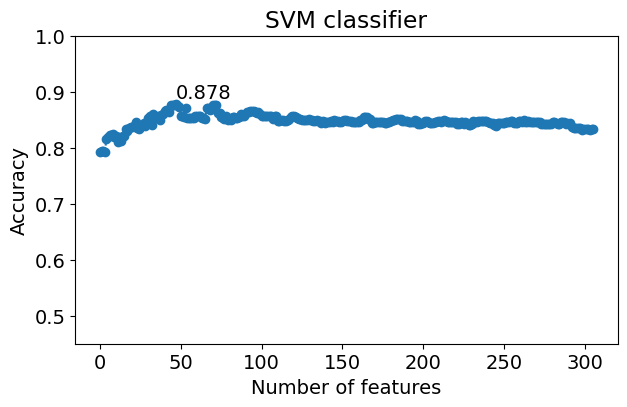

auc_best = 0.87780449
best auc (SVM) =  0.8778044871794872 Number of features =  47
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #0: 0.879 <-> 0.878
Iter #1: 0.879 <-> 0.878
Iter #2: 0.879 <-> 0.878
Iter #3: 0.879 <-> 0.878
Iter #6: 0.879 <-> 0.878
Iter #7: 0.882 <-> 0.878
Iter #11: 0.878 <-> 0.878
Iter #13: 0.888 <-> 0.878
Iter #23: 0.879 <-> 0.878
Iter #27: 0.879 <-> 0.878
Iter #30: 0.879 <-> 0.878
Iter #31: 0.880 <-> 0.878
Iter #32: 0.878 <-> 0.878
Iter #41: 0.880 <-> 0.878
Iter #45: 0.880 <-> 0.878
Iter #46: 0.879 <-> 0.878
Withdraw feature #13, added accracy 0.01041666666666663
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #8: 0.889 <-> 0.888
Iter #9: 0.891 <-> 0.888
Iter #10: 0.888 <-> 0.888
Iter #14: 0.889 <-> 0.888
Iter #15: 0.892 <-> 0.888
Iter #16: 0.892 <-> 0.888
Iter #17: 0.892 <-> 0.888
Iter #18: 0.892 <-> 0.888
Iter #20: 0.892 <-> 0.888
Iter #21: 0.892 <-> 0.888
Iter #22: 0.892 <-> 0.888
Iter #23: 0.892 <-> 0.888
Iter #24: 0.892 <-> 0.888
Iter #30: 0.890 <-> 0.888
Iter #34: 0.892 <-> 0.888
Iter #43: 0.889 <-> 0.888
Iter #44: 0.893 <-> 0.888
Iter #45: 0.891 <-> 0.888
Iter #46: 0.890 <-> 0.888
Withdraw feature #44, added accracy 0.005008012820512886
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #1: 0.894 <-> 0.893
Iter #7: 0.894 <-> 0.893
Iter #14: 0.894 <-> 0.893
Iter #15: 0.893 <-> 0.893
Iter #16: 0.893 <-> 0.893
Iter #17: 0.893 <-> 0.893
Iter #18: 0.893 <-> 0.893
Iter #19: 0.893 <-> 0.893
Iter #20: 0.893 <-> 0.893
Iter #21: 0.893 <-> 0.893
Iter #22: 0.893 <-> 0.893
Iter #23: 0.893 <-> 0.893
Iter #24: 0.893 <-> 0.893
Iter #34: 0.897 <-> 0.893
Withdraw feature #34, added accracy 0.004006410256410131
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #4: 0.900 <-> 0.897
Iter #5: 0.900 <-> 0.897
Iter #9: 0.900 <-> 0.897
Iter #10: 0.901 <-> 0.897
Iter #30: 0.900 <-> 0.897
Iter #38: 0.902 <-> 0.897
Iter #42: 0.904 <-> 0.897
Iter #44: 0.898 <-> 0.897
Withdraw feature #42, added accracy 0.0064102564102564985
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #3: 0.905 <-> 0.904
Iter #7: 0.906 <-> 0.904
Iter #25: 0.904 <-> 0.904
Iter #26: 0.904 <-> 0.904
Iter #27: 0.904 <-> 0.904
Iter #28: 0.904 <-> 0.904
Withdraw feature #7, added accracy 0.002203525641025661
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #1: 0.906 <-> 0.906
Iter #5: 0.907 <-> 0.906
Iter #24: 0.906 <-> 0.906
Iter #25: 0.906 <-> 0.906
Iter #26: 0.906 <-> 0.906
Iter #27: 0.906 <-> 0.906
Iter #29: 0.907 <-> 0.906
Withdraw feature #5, added accracy 0.0010016025641025328
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #1: 0.907 <-> 0.907
Iter #12: 0.907 <-> 0.907
Iter #13: 0.907 <-> 0.907
Iter #14: 0.907 <-> 0.907
Iter #15: 0.907 <-> 0.907
Iter #16: 0.907 <-> 0.907
Iter #18: 0.907 <-> 0.907
Iter #19: 0.907 <-> 0.907
Iter #20: 0.907 <-> 0.907
Iter #21: 0.907 <-> 0.907
Iter #22: 0.907 <-> 0.907
Iter #23: 0.907 <-> 0.907
Iter #24: 0.907 <-> 0.907
Iter #25: 0.907 <-> 0.907
Iter #26: 0.907 <-> 0.907
Iter #28: 0.908 <-> 0.907
Iter #39: 0.908 <-> 0.907
Withdraw feature #28, added accracy 0.0012019230769230171
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #1: 0.908 <-> 0.908
Iter #4: 0.908 <-> 0.908
Iter #13: 0.908 <-> 0.908
Iter #14: 0.908 <-> 0.908
Iter #15: 0.908 <-> 0.908
Iter #16: 0.908 <-> 0.908
Iter #17: 0.908 <-> 0.908
Iter #23: 0.908 <-> 0.908
Iter #24: 0.908 <-> 0.908
Iter #25: 0.908 <-> 0.908
Iter #26: 0.908 <-> 0.908
Iter #33: 0.908 <-> 0.908
Withdraw feature #1, added accracy 0.0
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #2: 0.911 <-> 0.908
Iter #5: 0.908 <-> 0.908
Iter #12: 0.908 <-> 0.908
Iter #13: 0.908 <-> 0.908
Iter #14: 0.908 <-> 0.908
Iter #15: 0.908 <-> 0.908
Iter #22: 0.908 <-> 0.908
Iter #23: 0.908 <-> 0.908
Iter #24: 0.908 <-> 0.908
Iter #25: 0.908 <-> 0.908
Iter #32: 0.909 <-> 0.908
Iter #37: 0.908 <-> 0.908
Withdraw feature #2, added accracy 0.003405448717948789
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #10: 0.912 <-> 0.911
Iter #15: 0.913 <-> 0.911
Iter #21: 0.912 <-> 0.911
Iter #22: 0.912 <-> 0.911
Iter #23: 0.912 <-> 0.911
Iter #24: 0.912 <-> 0.911
Withdraw feature #15, added accracy 0.0012019230769230171
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #10: 0.913 <-> 0.913
Iter #15: 0.913 <-> 0.913
Iter #16: 0.913 <-> 0.913
Iter #17: 0.913 <-> 0.913
Iter #18: 0.913 <-> 0.913
Iter #19: 0.913 <-> 0.913
Withdraw feature #10, added accracy 0.00040064102564107973
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #14: 0.913 <-> 0.913
Iter #15: 0.913 <-> 0.913
Iter #16: 0.913 <-> 0.913
Iter #17: 0.913 <-> 0.913
Iter #18: 0.913 <-> 0.913
Iter #19: 0.913 <-> 0.913
Iter #20: 0.913 <-> 0.913
Iter #21: 0.913 <-> 0.913
Iter #22: 0.913 <-> 0.913
Withdraw feature #14, added accracy 0.0
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #14: 0.913 <-> 0.913
Iter #15: 0.913 <-> 0.913
Iter #16: 0.913 <-> 0.913
Iter #17: 0.913 <-> 0.913
Withdraw feature #14, added accracy 0.0
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #17: 0.913 <-> 0.913
Iter #18: 0.913 <-> 0.913
Iter #19: 0.913 <-> 0.913
Iter #20: 0.913 <-> 0.913
Withdraw feature #17, added accracy 0.0
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #17: 0.913 <-> 0.913
Iter #18: 0.913 <-> 0.913
Iter #19: 0.913 <-> 0.913
Withdraw feature #17, added accracy 0.0
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)
 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.84it/s]

UAR = 0.358


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.80it/s]

UAR = 0.361


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 20.32it/s]

UAR = 0.365


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.32it/s]

UAR = 0.377


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 20.57it/s]

UAR = 0.383


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 20.53it/s]

UAR = 0.394


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 20.95it/s]

UAR = 0.400


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.15it/s]

UAR = 0.405


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 22.86it/s]

UAR = 0.409


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 22.14it/s]

UAR = 0.410


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 22.76it/s]

UAR = 0.406


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 22.73it/s]

UAR = 0.408


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 22.77it/s]

UAR = 0.408


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 23.31it/s]

UAR = 0.405


  0%|                                                                                                                                                                                                | 0/5 [00:00<?, ?it/s]

UAR = 0.419
UAR = 0.426


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 24.57it/s]

UAR = 0.424


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 23.92it/s]

UAR = 0.417


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 23.42it/s]

UAR = 0.417


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 22.93it/s]

UAR = 0.414


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.95it/s]

UAR = 0.424



 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 24.81it/s]

UAR = 0.419


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 23.10it/s]

UAR = 0.417


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 23.19it/s]

UAR = 0.412


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 22.46it/s]

UAR = 0.410


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 23.75it/s]

UAR = 0.409


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 23.45it/s]

UAR = 0.410


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 22.53it/s]

UAR = 0.412


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 21.19it/s]

UAR = 0.410


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 21.93it/s]

UAR = 0.410


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.66it/s]

UAR = 0.409


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.45it/s]

UAR = 0.408


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.75it/s]

UAR = 0.405


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.82it/s]

UAR = 0.406


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 13.45it/s]

UAR = 0.404


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 12.16it/s]

UAR = 0.398


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 11.42it/s]

UAR = 0.398


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.56it/s]

UAR = 0.403


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  7.81it/s]

UAR = 0.396


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


UAR = 0.391


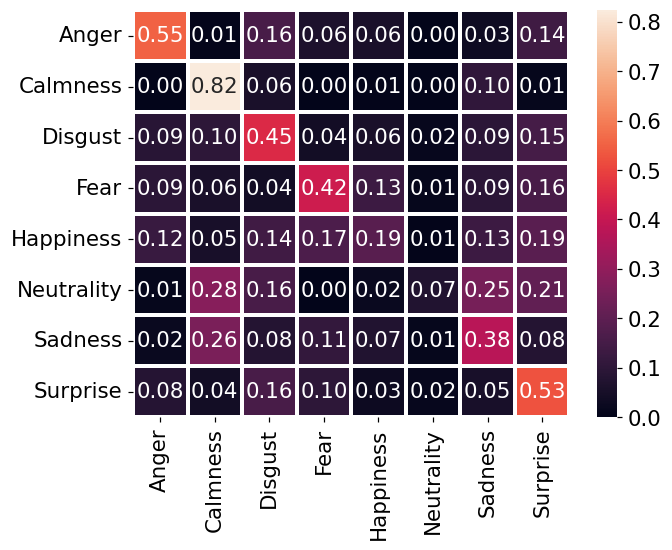

Saving confusion matrix with name:  confusion_matrix_SVM_calm.jpg


  0%|                                                                                                                                                                                              | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.565e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
  0%|▉                                                                                                                                                                                     | 1/200 [00:10<33:38, 10.14s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

  8%|█████████████▌                                                                                                                                                                       | 15/200 [02:14<27:08,  8.80s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.565e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
  8%|██████████████▍                                                                                                                                                                      | 16/200 [02:22<26:40,  8.70s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 15%|███████████████████████████▏                                                                                                                                                         | 30/200 [04:35<29:21, 10.36s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.562e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
 16%|████████████████████████████                                                                                                                                                         | 31/200 [04:47<30:31, 10.84s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 22%|████████████████████████████████████████▋                                                                                                                                            | 45/200 [06:54<22:47,  8.82s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.537e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
 23%|█████████████████████████████████████████▋                                                                                                                                           | 46/200 [07:02<22:30,  8.77s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 30%|██████████████████████████████████████████████████████▎                                                                                                                              | 60/200 [09:06<20:36,  8.83s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.325e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
 30%|███████████████████████████████████████████████████████▏                                                                                                                             | 61/200 [09:14<20:07,  8.69s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 38%|███████████████████████████████████████████████████████████████████▉                                                                                                                 | 75/200 [11:17<18:21,  8.81s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.202e+01, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
 38%|████████████████████████████████████████████████████████████████████▊                                                                                                                | 76/200 [11:25<18:14,  8.83s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 45%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 90/200 [13:29<16:12,  8.84s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.875e+01, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
 46%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 91/200 [13:38<15:58,  8.79s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 52%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 105/200 [15:39<13:39,  8.63s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.249e+01, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
 53%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 106/200 [15:47<13:24,  8.55s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 120/200 [17:42<10:30,  7.88s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.073e+01, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 121/200 [17:48<09:45,  7.42s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [19:55<00:00,  5.98s/it]


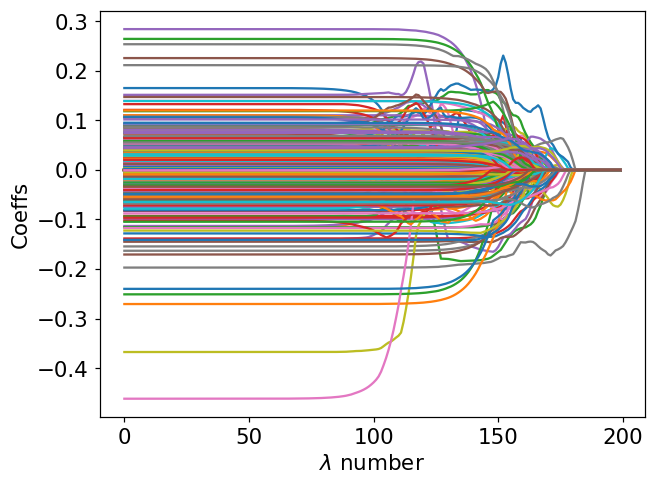

  0%|▌                                                                                                                                                                                     | 1/306 [00:00<04:27,  1.14it/s]

Iter =  1  AUC = 0.6899


  1%|█▏                                                                                                                                                                                    | 2/306 [00:01<04:22,  1.16it/s]

Iter =  2  AUC = 0.7005


  1%|█▊                                                                                                                                                                                    | 3/306 [00:02<04:14,  1.19it/s]

Iter =  3  AUC = 0.7099


  2%|██▉                                                                                                                                                                                   | 5/306 [00:04<04:07,  1.21it/s]

Iter =  5  AUC = 0.7432


  2%|███▌                                                                                                                                                                                  | 6/306 [00:04<04:03,  1.23it/s]

Iter =  6  AUC = 0.7534


  3%|████▊                                                                                                                                                                                 | 8/306 [00:06<03:58,  1.25it/s]

Iter =  8  AUC = 0.7606


  3%|█████▉                                                                                                                                                                               | 10/306 [00:08<04:07,  1.20it/s]

Iter =  10  AUC = 0.7642


  4%|██████▌                                                                                                                                                                              | 11/306 [00:09<04:13,  1.16it/s]

Iter =  11  AUC = 0.7700


  4%|███████                                                                                                                                                                              | 12/306 [00:09<04:08,  1.18it/s]

Iter =  12  AUC = 0.7885


  4%|███████▋                                                                                                                                                                             | 13/306 [00:10<04:11,  1.17it/s]

Iter =  13  AUC = 0.7911


  5%|████████▎                                                                                                                                                                            | 14/306 [00:11<04:14,  1.15it/s]

Iter =  14  AUC = 0.7935


  5%|████████▊                                                                                                                                                                            | 15/306 [00:12<04:13,  1.15it/s]

Iter =  15  AUC = 0.7949


  5%|█████████▍                                                                                                                                                                           | 16/306 [00:13<04:08,  1.16it/s]

Iter =  16  AUC = 0.8053


  6%|██████████                                                                                                                                                                           | 17/306 [00:14<04:06,  1.17it/s]

Iter =  17  AUC = 0.8059


  6%|██████████▋                                                                                                                                                                          | 18/306 [00:15<04:07,  1.16it/s]

Iter =  18  AUC = 0.8117


  7%|███████████▊                                                                                                                                                                         | 20/306 [00:16<04:12,  1.13it/s]

Iter =  20  AUC = 0.8161


  8%|██████████████▏                                                                                                                                                                      | 24/306 [00:21<04:39,  1.01it/s]

Iter =  24  AUC = 0.8229


 14%|█████████████████████████▍                                                                                                                                                           | 43/306 [00:40<04:50,  1.11s/it]

Iter =  43  AUC = 0.8271


 15%|██████████████████████████▌                                                                                                                                                          | 45/306 [00:42<04:34,  1.05s/it]

Iter =  45  AUC = 0.8323


 22%|███████████████████████████████████████                                                                                                                                              | 66/306 [01:05<04:10,  1.04s/it]

Iter =  66  AUC = 0.8423


 24%|██████████████████████████████████████████▌                                                                                                                                          | 72/306 [01:11<03:53,  1.00it/s]

Iter =  72  AUC = 0.8476


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 306/306 [06:54<00:00,  1.35s/it]


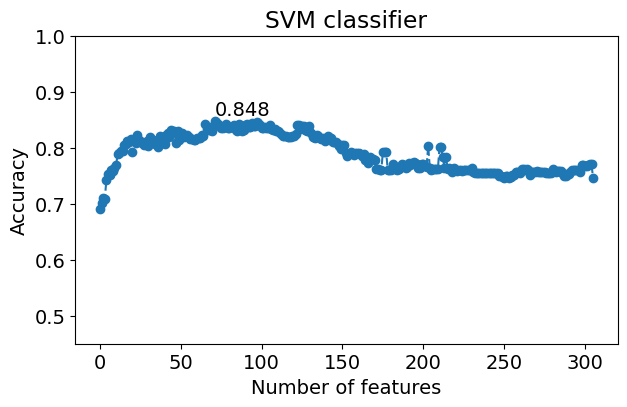

auc_best = 0.84755609
best auc (SVM) =  0.8475560897435898 Number of features =  71
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #4: 0.851 <-> 0.848
Iter #6: 0.849 <-> 0.848
Iter #10: 0.854 <-> 0.848
Iter #15: 0.849 <-> 0.848
Iter #22: 0.849 <-> 0.848
Iter #23: 0.850 <-> 0.848
Iter #25: 0.856 <-> 0.848
Iter #33: 0.852 <-> 0.848
Iter #37: 0.850 <-> 0.848
Iter #38: 0.848 <-> 0.848
Iter #39: 0.854 <-> 0.848
Iter #42: 0.851 <-> 0.848
Iter #48: 0.854 <-> 0.848
Iter #55: 0.852 <-> 0.848
Iter #56: 0.848 <-> 0.848
Iter #57: 0.848 <-> 0.848
Iter #61: 0.849 <-> 0.848
Iter #63: 0.848 <-> 0.848
Iter #64: 0.848 <-> 0.848
Iter #68: 0.848 <-> 0.848
Iter #69: 0.850 <-> 0.848
Withdraw feature #25, added accracy 0.008012820512820484
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #8: 0.866 <-> 0.856
Iter #13: 0.860 <-> 0.856
Iter #25: 0.865 <-> 0.856
Iter #27: 0.856 <-> 0.856
Iter #33: 0.857 <-> 0.856
Iter #34: 0.859 <-> 0.856
Iter #43: 0.856 <-> 0.856
Iter #56: 0.858 <-> 0.856
Iter #58: 0.856 <-> 0.856
Iter #60: 0.858 <-> 0.856
Iter #66: 0.862 <-> 0.856
Withdraw feature #8, added accracy 0.010616987179487114
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #24: 0.867 <-> 0.866
Iter #26: 0.867 <-> 0.866
Iter #34: 0.867 <-> 0.866
Withdraw feature #24, added accracy 0.0008012820512821595
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #20: 0.867 <-> 0.867
Iter #25: 0.869 <-> 0.867
Iter #27: 0.871 <-> 0.867
Iter #33: 0.867 <-> 0.867
Iter #38: 0.868 <-> 0.867
Iter #45: 0.870 <-> 0.867
Iter #46: 0.868 <-> 0.867
Iter #47: 0.868 <-> 0.867
Iter #55: 0.869 <-> 0.867
Withdraw feature #27, added accracy 0.004006410256410242
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #11: 0.871 <-> 0.871
Withdraw feature #11, added accracy 0.00040064102564107973
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #24: 0.874 <-> 0.871
Iter #35: 0.873 <-> 0.871
Iter #43: 0.872 <-> 0.871
Withdraw feature #24, added accracy 0.00220352564102555
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #42: 0.876 <-> 0.874
Withdraw feature #42, added accracy 0.0026041666666667407
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #4: 0.876 <-> 0.876
Withdraw feature #4, added accracy 0.00020032051282048435
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #27: 0.879 <-> 0.876
Withdraw feature #27, added accracy 0.0024038461538461453
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #10: 0.879 <-> 0.879
Iter #32: 0.879 <-> 0.879
Withdraw feature #10, added accracy 0.0
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #27: 0.879 <-> 0.879
Iter #31: 0.879 <-> 0.879
Withdraw feature #31, added accracy 0.00040064102564107973
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #27: 0.879 <-> 0.879
Withdraw feature #27, added accracy 0.0
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)
 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 13.50it/s]

UAR = 0.321


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 12.87it/s]

UAR = 0.324


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 14.04it/s]

UAR = 0.343


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 13.32it/s]

UAR = 0.350


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 12.92it/s]

UAR = 0.372


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.51it/s]

UAR = 0.380


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 14.45it/s]

UAR = 0.395


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.20it/s]

UAR = 0.412


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.45it/s]

UAR = 0.417


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 14.08it/s]

UAR = 0.421


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.75it/s]

UAR = 0.421


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.22it/s]

UAR = 0.427


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.70it/s]

UAR = 0.428


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.44it/s]

UAR = 0.427


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.82it/s]

UAR = 0.430


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.11it/s]

UAR = 0.434


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.48it/s]

UAR = 0.439


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.21it/s]

UAR = 0.441


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.82it/s]

UAR = 0.443


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.66it/s]

UAR = 0.450


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.22it/s]

UAR = 0.453


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.01it/s]

UAR = 0.453


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.73it/s]

UAR = 0.448


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.63it/s]

UAR = 0.454


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.64it/s]

UAR = 0.452


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.29it/s]

UAR = 0.457


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.87it/s]

UAR = 0.453


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.17it/s]

UAR = 0.451


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.29it/s]

UAR = 0.451


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.34it/s]

UAR = 0.454


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 13.64it/s]

UAR = 0.452


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 14.04it/s]

UAR = 0.447


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 12.54it/s]

UAR = 0.444


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 11.90it/s]

UAR = 0.432


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 11.14it/s]

UAR = 0.425


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.46it/s]

UAR = 0.421


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  8.46it/s]

UAR = 0.414


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  8.09it/s]

UAR = 0.402


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  8.07it/s]

UAR = 0.404


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


UAR = 0.399


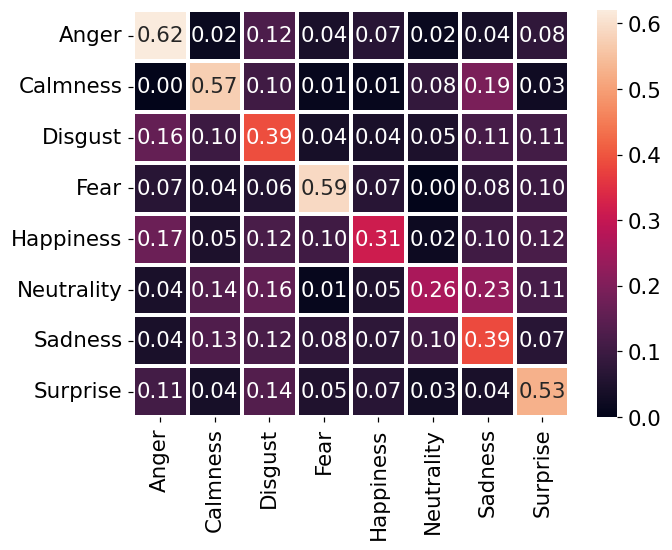

  0%|                                                                                                                                                                                              | 0/200 [00:00<?, ?it/s]

Saving confusion matrix with name:  confusion_matrix_SVM_fear.jpg


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.662e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
  0%|▉                                                                                                                                                                                     | 1/200 [00:08<27:58,  8.43s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.662e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
  1%|█▊                                                                              

  8%|█████████████▌                                                                                                                                                                       | 15/200 [02:13<28:00,  9.09s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.662e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
  8%|██████████████▍                                                                                                                                                                      | 16/200 [02:22<27:49,  9.07s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 15%|███████████████████████████▏                                                                                                                                                         | 30/200 [04:39<27:50,  9.83s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.660e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
 16%|████████████████████████████                                                                                                                                                         | 31/200 [04:50<28:33, 10.14s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 22%|████████████████████████████████████████▋                                                                                                                                            | 45/200 [07:02<22:49,  8.84s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.646e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
 23%|█████████████████████████████████████████▋                                                                                                                                           | 46/200 [07:11<22:17,  8.68s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 30%|██████████████████████████████████████████████████████▎                                                                                                                              | 60/200 [09:13<20:43,  8.88s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.516e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
 30%|███████████████████████████████████████████████████████▏                                                                                                                             | 61/200 [09:22<20:24,  8.81s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 38%|███████████████████████████████████████████████████████████████████▉                                                                                                                 | 75/200 [11:32<19:26,  9.33s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.646e+01, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
 38%|████████████████████████████████████████████████████████████████████▊                                                                                                                | 76/200 [11:41<18:58,  9.18s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 45%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 90/200 [13:44<16:26,  8.97s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.244e+01, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
 46%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 91/200 [13:54<16:29,  9.08s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 52%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 105/200 [16:04<15:00,  9.47s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.122e+01, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
 53%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 106/200 [16:13<14:30,  9.27s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 120/200 [18:11<11:00,  8.25s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.867e+00, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 121/200 [18:20<10:51,  8.25s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

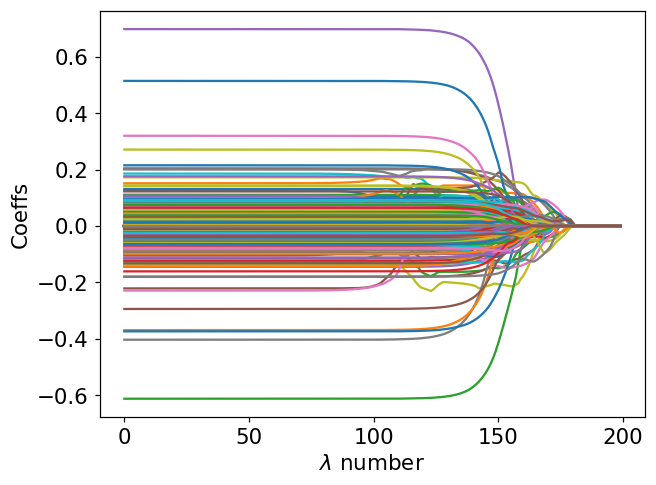

  0%|▌                                                                                                                                                                                     | 1/306 [00:00<04:45,  1.07it/s]

Iter =  1  AUC = 0.5893


  1%|█▏                                                                                                                                                                                    | 2/306 [00:01<04:50,  1.05it/s]

Iter =  2  AUC = 0.6450


  1%|█▊                                                                                                                                                                                    | 3/306 [00:03<05:02,  1.00it/s]

Iter =  3  AUC = 0.6885


  2%|██▉                                                                                                                                                                                   | 5/306 [00:04<04:55,  1.02it/s]

Iter =  5  AUC = 0.6937


  2%|███▌                                                                                                                                                                                  | 6/306 [00:05<04:51,  1.03it/s]

Iter =  6  AUC = 0.7141


  2%|████▏                                                                                                                                                                                 | 7/306 [00:06<04:57,  1.01it/s]

Iter =  7  AUC = 0.7177


  3%|████▊                                                                                                                                                                                 | 8/306 [00:07<04:45,  1.05it/s]

Iter =  8  AUC = 0.7402


  3%|█████▉                                                                                                                                                                               | 10/306 [00:09<04:35,  1.08it/s]

Iter =  10  AUC = 0.7464


  4%|███████▋                                                                                                                                                                             | 13/306 [00:12<04:52,  1.00it/s]

Iter =  13  AUC = 0.7468


  5%|████████▎                                                                                                                                                                            | 14/306 [00:13<05:03,  1.04s/it]

Iter =  14  AUC = 0.7562


  5%|████████▊                                                                                                                                                                            | 15/306 [00:15<05:49,  1.20s/it]

Iter =  15  AUC = 0.7702


  6%|██████████                                                                                                                                                                           | 17/306 [00:17<05:09,  1.07s/it]

Iter =  17  AUC = 0.7724


  6%|███████████▏                                                                                                                                                                         | 19/306 [00:19<04:53,  1.02s/it]

Iter =  19  AUC = 0.7774


  7%|████████████▍                                                                                                                                                                        | 21/306 [00:21<04:55,  1.04s/it]

Iter =  21  AUC = 0.7835


  7%|█████████████                                                                                                                                                                        | 22/306 [00:22<05:07,  1.08s/it]

Iter =  22  AUC = 0.7943


 10%|█████████████████▋                                                                                                                                                                   | 30/306 [00:35<09:40,  2.10s/it]

Iter =  30  AUC = 0.8029


 28%|███████████████████████████████████████████████████▍                                                                                                                                 | 87/306 [02:02<04:50,  1.33s/it]

Iter =  87  AUC = 0.8069


 29%|████████████████████████████████████████████████████                                                                                                                                 | 88/306 [02:03<04:51,  1.34s/it]

Iter =  88  AUC = 0.8095


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 306/306 [10:42<00:00,  2.10s/it]


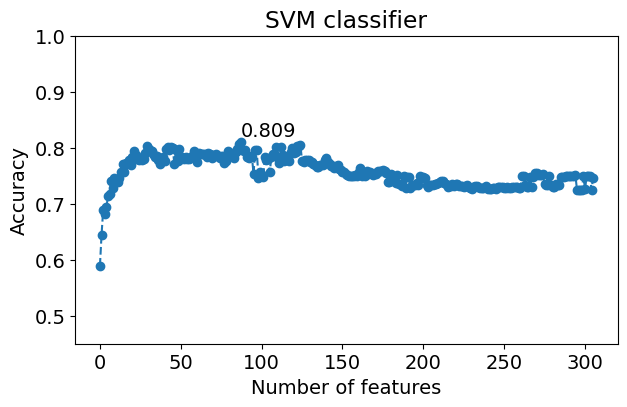

auc_best = 0.80949519
best auc (SVM) =  0.8094951923076923 Number of features =  87
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #0: 0.812 <-> 0.809
Iter #14: 0.810 <-> 0.809
Iter #16: 0.811 <-> 0.809
Iter #20: 0.812 <-> 0.809
Iter #21: 0.814 <-> 0.809
Iter #22: 0.809 <-> 0.809
Iter #27: 0.813 <-> 0.809
Iter #28: 0.811 <-> 0.809
Iter #39: 0.810 <-> 0.809
Iter #42: 0.810 <-> 0.809
Iter #43: 0.811 <-> 0.809
Iter #44: 0.811 <-> 0.809
Iter #49: 0.816 <-> 0.809
Iter #50: 0.810 <-> 0.809
Iter #52: 0.811 <-> 0.809
Iter #53: 0.811 <-> 0.809
Iter #54: 0.811 <-> 0.809
Iter #55: 0.809 <-> 0.809
Iter #62: 0.809 <-> 0.809
Iter #63: 0.809 <-> 0.809
Iter #64: 0.811 <-> 0.809
Iter #65: 0.812 <-> 0.809
Iter #67: 0.812 <-> 0.809
Iter #68: 0.812 <-> 0.809
Iter #73: 0.810 <-> 0.809
Iter #74: 0.810 <-> 0.809
Iter #75: 0.809 <-> 0.809
Iter #76: 0.809 <-> 0.809
Iter #79: 0.812 <-> 0.809
Iter #80: 0.810 <-> 0.809
Iter #81: 0.810 <-> 0.809
Withdraw feature #49, added accracy 0.0064102564102563875
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #6: 0.816 <-> 0.816
Iter #14: 0.816 <-> 0.816
Iter #16: 0.819 <-> 0.816
Iter #21: 0.820 <-> 0.816
Iter #32: 0.818 <-> 0.816
Iter #37: 0.816 <-> 0.816
Iter #38: 0.816 <-> 0.816
Iter #39: 0.816 <-> 0.816
Iter #40: 0.816 <-> 0.816
Iter #41: 0.816 <-> 0.816
Iter #50: 0.816 <-> 0.816
Iter #70: 0.818 <-> 0.816
Iter #81: 0.816 <-> 0.816
Withdraw feature #21, added accracy 0.0042067307692308376
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #6: 0.822 <-> 0.820
Iter #12: 0.820 <-> 0.820
Iter #16: 0.821 <-> 0.820
Iter #21: 0.821 <-> 0.820
Iter #22: 0.821 <-> 0.820
Iter #23: 0.821 <-> 0.820
Iter #24: 0.821 <-> 0.820
Iter #31: 0.822 <-> 0.820
Iter #36: 0.820 <-> 0.820
Iter #37: 0.820 <-> 0.820
Iter #38: 0.820 <-> 0.820
Iter #39: 0.820 <-> 0.820
Iter #40: 0.820 <-> 0.820
Iter #41: 0.820 <-> 0.820
Iter #42: 0.820 <-> 0.820
Iter #43: 0.820 <-> 0.820
Iter #44: 0.820 <-> 0.820
Iter #45: 0.820 <-> 0.820
Iter #54: 0.821 <-> 0.820
Iter #60: 0.823 <-> 0.820
Iter #64: 0.821 <-> 0.820
Iter #68: 0.821 <-> 0.820
Iter #69: 0.821 <-> 0.820
Iter #71: 0.821 <-> 0.820
Withdraw feature #60, added accracy 0.002804487179487114
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #6: 0.823 <-> 0.823
Iter #12: 0.823 <-> 0.823
Iter #14: 0.823 <-> 0.823
Iter #16: 0.824 <-> 0.823
Iter #31: 0.825 <-> 0.823
Iter #36: 0.823 <-> 0.823
Iter #37: 0.823 <-> 0.823
Iter #38: 0.823 <-> 0.823
Iter #39: 0.823 <-> 0.823
Iter #40: 0.823 <-> 0.823
Iter #41: 0.823 <-> 0.823
Iter #42: 0.823 <-> 0.823
Iter #43: 0.823 <-> 0.823
Iter #44: 0.823 <-> 0.823
Iter #45: 0.823 <-> 0.823
Iter #49: 0.824 <-> 0.823
Iter #67: 0.825 <-> 0.823
Iter #70: 0.826 <-> 0.823
Iter #79: 0.823 <-> 0.823
Withdraw feature #70, added accracy 0.003405448717948789
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #6: 0.828 <-> 0.826
Iter #12: 0.826 <-> 0.826
Iter #16: 0.827 <-> 0.826
Iter #21: 0.826 <-> 0.826
Iter #22: 0.826 <-> 0.826
Iter #23: 0.826 <-> 0.826
Iter #24: 0.826 <-> 0.826
Iter #31: 0.827 <-> 0.826
Iter #36: 0.828 <-> 0.826
Iter #37: 0.828 <-> 0.826
Iter #38: 0.828 <-> 0.826
Iter #39: 0.828 <-> 0.826
Iter #40: 0.828 <-> 0.826
Iter #41: 0.827 <-> 0.826
Iter #42: 0.827 <-> 0.826
Iter #43: 0.827 <-> 0.826
Iter #44: 0.827 <-> 0.826
Iter #45: 0.827 <-> 0.826
Iter #67: 0.828 <-> 0.826
Withdraw feature #6, added accracy 0.0012019230769230171
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #11: 0.828 <-> 0.828
Iter #13: 0.828 <-> 0.828
Iter #30: 0.828 <-> 0.828
Iter #45: 0.829 <-> 0.828
Iter #47: 0.828 <-> 0.828
Iter #53: 0.828 <-> 0.828
Iter #66: 0.828 <-> 0.828
Withdraw feature #45, added accracy 0.0014022435897436125
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #15: 0.830 <-> 0.829
Iter #20: 0.829 <-> 0.829
Iter #21: 0.829 <-> 0.829
Iter #22: 0.829 <-> 0.829
Iter #23: 0.829 <-> 0.829
Iter #46: 0.829 <-> 0.829
Iter #76: 0.830 <-> 0.829
Withdraw feature #76, added accracy 0.0012019230769230171
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #13: 0.834 <-> 0.830
Iter #15: 0.831 <-> 0.830
Iter #20: 0.831 <-> 0.830
Iter #21: 0.831 <-> 0.830
Iter #22: 0.831 <-> 0.830
Iter #23: 0.831 <-> 0.830
Iter #30: 0.830 <-> 0.830
Iter #35: 0.830 <-> 0.830
Iter #36: 0.830 <-> 0.830
Iter #37: 0.830 <-> 0.830
Iter #38: 0.830 <-> 0.830
Iter #39: 0.830 <-> 0.830
Iter #40: 0.830 <-> 0.830
Iter #41: 0.830 <-> 0.830
Iter #42: 0.830 <-> 0.830
Iter #43: 0.830 <-> 0.830
Iter #44: 0.830 <-> 0.830
Iter #46: 0.832 <-> 0.830
Iter #47: 0.834 <-> 0.830
Withdraw feature #13, added accracy 0.0042067307692308376
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #34: 0.834 <-> 0.834
Iter #35: 0.834 <-> 0.834
Iter #36: 0.834 <-> 0.834
Iter #37: 0.834 <-> 0.834
Iter #38: 0.834 <-> 0.834
Iter #39: 0.834 <-> 0.834
Iter #40: 0.834 <-> 0.834
Iter #41: 0.834 <-> 0.834
Iter #42: 0.834 <-> 0.834
Iter #43: 0.834 <-> 0.834
Iter #45: 0.836 <-> 0.834
Iter #64: 0.838 <-> 0.834
Iter #78: 0.837 <-> 0.834
Withdraw feature #64, added accracy 0.003806089743589758
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #19: 0.838 <-> 0.838
Iter #20: 0.838 <-> 0.838
Iter #21: 0.838 <-> 0.838
Iter #22: 0.838 <-> 0.838
Iter #34: 0.838 <-> 0.838
Iter #35: 0.838 <-> 0.838
Iter #36: 0.838 <-> 0.838
Iter #37: 0.838 <-> 0.838
Iter #38: 0.838 <-> 0.838
Iter #39: 0.838 <-> 0.838
Iter #40: 0.838 <-> 0.838
Iter #41: 0.838 <-> 0.838
Iter #42: 0.838 <-> 0.838
Iter #43: 0.838 <-> 0.838
Iter #45: 0.840 <-> 0.838
Iter #46: 0.839 <-> 0.838
Iter #60: 0.840 <-> 0.838
Withdraw feature #45, added accracy 0.002203525641025661
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #11: 0.841 <-> 0.840
Iter #34: 0.840 <-> 0.840
Iter #35: 0.840 <-> 0.840
Iter #36: 0.840 <-> 0.840
Iter #37: 0.840 <-> 0.840
Iter #38: 0.840 <-> 0.840
Iter #74: 0.841 <-> 0.840
Withdraw feature #11, added accracy 0.0008012820512820484
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #13: 0.842 <-> 0.841
Iter #33: 0.842 <-> 0.841
Iter #34: 0.842 <-> 0.841
Iter #35: 0.842 <-> 0.841
Iter #36: 0.842 <-> 0.841
Iter #37: 0.842 <-> 0.841
Iter #38: 0.842 <-> 0.841
Iter #39: 0.842 <-> 0.841
Iter #40: 0.842 <-> 0.841
Iter #41: 0.842 <-> 0.841
Iter #42: 0.842 <-> 0.841
Iter #73: 0.842 <-> 0.841
Withdraw feature #33, added accracy 0.0012019230769230171
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #33: 0.842 <-> 0.842
Iter #34: 0.842 <-> 0.842
Iter #35: 0.842 <-> 0.842
Iter #36: 0.842 <-> 0.842
Iter #57: 0.843 <-> 0.842
Withdraw feature #57, added accracy 0.00040064102564107973
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #13: 0.848 <-> 0.843
Iter #37: 0.843 <-> 0.843
Iter #38: 0.843 <-> 0.843
Iter #39: 0.843 <-> 0.843
Iter #40: 0.843 <-> 0.843
Iter #41: 0.843 <-> 0.843
Iter #60: 0.844 <-> 0.843
Iter #71: 0.843 <-> 0.843
Withdraw feature #13, added accracy 0.004807692307692291
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #17: 0.848 <-> 0.848
Iter #18: 0.848 <-> 0.848
Iter #19: 0.848 <-> 0.848
Iter #20: 0.848 <-> 0.848
Iter #36: 0.848 <-> 0.848
Iter #37: 0.848 <-> 0.848
Iter #38: 0.848 <-> 0.848
Iter #39: 0.848 <-> 0.848
Iter #40: 0.848 <-> 0.848
Withdraw feature #36, added accracy 0.00040064102564107973
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #36: 0.848 <-> 0.848
Iter #37: 0.848 <-> 0.848
Iter #38: 0.848 <-> 0.848
Iter #39: 0.848 <-> 0.848
Withdraw feature #36, added accracy 0.0
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #17: 0.848 <-> 0.848
Iter #18: 0.848 <-> 0.848
Iter #19: 0.848 <-> 0.848
Iter #20: 0.848 <-> 0.848
Withdraw feature #17, added accracy 0.0
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #31: 0.848 <-> 0.848
Iter #32: 0.848 <-> 0.848
Iter #33: 0.848 <-> 0.848
Iter #34: 0.848 <-> 0.848
Iter #44: 0.849 <-> 0.848
Withdraw feature #44, added accracy 0.0008012820512819374
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #31: 0.849 <-> 0.849
Iter #32: 0.849 <-> 0.849
Iter #33: 0.849 <-> 0.849
Iter #34: 0.849 <-> 0.849
Withdraw feature #31, added accracy 0.0
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #67: 0.849 <-> 0.849
Withdraw feature #67, added accracy 0.0
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)
 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.54it/s]

UAR = 0.331


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.50it/s]

UAR = 0.340


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 14.60it/s]

UAR = 0.350


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.68it/s]

UAR = 0.366


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.77it/s]

UAR = 0.380


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.05it/s]

UAR = 0.395


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.85it/s]

UAR = 0.399


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.71it/s]

UAR = 0.400


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.01it/s]

UAR = 0.409


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.88it/s]

UAR = 0.410


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.32it/s]

UAR = 0.410


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.96it/s]

UAR = 0.413


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.08it/s]

UAR = 0.414


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.62it/s]

UAR = 0.418


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 20.88it/s]

UAR = 0.420


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.65it/s]

UAR = 0.419


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.28it/s]

UAR = 0.419


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.95it/s]

UAR = 0.428


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 20.87it/s]

UAR = 0.424


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 21.04it/s]

UAR = 0.428


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.16it/s]

UAR = 0.426


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.93it/s]

UAR = 0.429


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.93it/s]

UAR = 0.432


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 20.78it/s]

UAR = 0.431


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 20.46it/s]

UAR = 0.434


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.74it/s]

UAR = 0.427


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.61it/s]

UAR = 0.427


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.17it/s]

UAR = 0.436


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.35it/s]

UAR = 0.434


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.04it/s]

UAR = 0.426


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 14.93it/s]

UAR = 0.434


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 13.70it/s]

UAR = 0.436


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 12.39it/s]

UAR = 0.424


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 10.55it/s]

UAR = 0.427


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  8.98it/s]

UAR = 0.418


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.30it/s]

UAR = 0.411


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  7.19it/s]

UAR = 0.413


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  7.21it/s]

UAR = 0.412


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  5.64it/s]

UAR = 0.412


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


UAR = 0.415


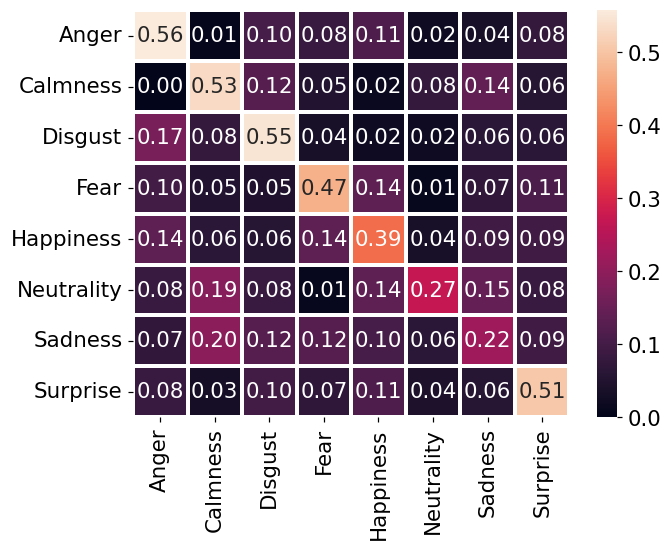

Saving confusion matrix with name:  confusion_matrix_SVM_disgust.jpg


  0%|                                                                                                                                                                                              | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.628e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
  0%|▉                                                                                                                                                                                     | 1/200 [00:10<35:54, 10.83s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

  8%|█████████████▌                                                                                                                                                                       | 15/200 [03:03<37:41, 12.22s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.628e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
  8%|██████████████▍                                                                                                                                                                      | 16/200 [03:12<34:53, 11.38s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 15%|███████████████████████████▏                                                                                                                                                         | 30/200 [05:56<35:24, 12.50s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.627e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
 16%|████████████████████████████                                                                                                                                                         | 31/200 [06:09<35:41, 12.67s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 22%|████████████████████████████████████████▋                                                                                                                                            | 45/200 [08:30<25:37,  9.92s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.614e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
 23%|█████████████████████████████████████████▋                                                                                                                                           | 46/200 [08:39<24:58,  9.73s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 30%|██████████████████████████████████████████████████████▎                                                                                                                              | 60/200 [10:40<20:15,  8.69s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.499e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
 30%|███████████████████████████████████████████████████████▏                                                                                                                             | 61/200 [10:48<19:56,  8.61s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 38%|███████████████████████████████████████████████████████████████████▉                                                                                                                 | 75/200 [12:45<17:32,  8.42s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.013e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
 38%|████████████████████████████████████████████████████████████████████▊                                                                                                                | 76/200 [12:55<18:04,  8.74s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 45%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 90/200 [14:53<15:32,  8.48s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.018e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
 46%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 91/200 [15:02<15:18,  8.43s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 52%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 105/200 [17:16<16:03, 10.14s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.595e+01, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
 53%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 106/200 [17:29<16:49, 10.74s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 120/200 [19:59<13:36, 10.20s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.377e+01, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 121/200 [20:07<12:33,  9.53s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

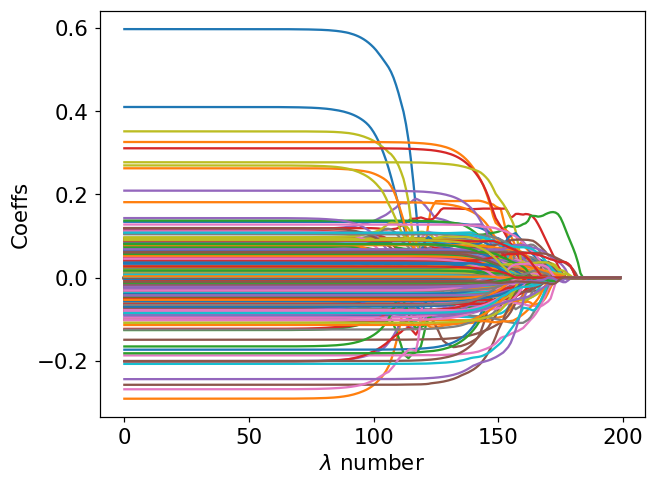

  0%|▌                                                                                                                                                                                     | 1/306 [00:00<04:05,  1.24it/s]

Iter =  1  AUC = 0.6855


  2%|██▉                                                                                                                                                                                   | 5/306 [00:04<04:05,  1.23it/s]

Iter =  5  AUC = 0.7376


  2%|████▏                                                                                                                                                                                 | 7/306 [00:06<04:50,  1.03it/s]

Iter =  7  AUC = 0.7584


  3%|████▊                                                                                                                                                                                 | 8/306 [00:07<04:33,  1.09it/s]

Iter =  8  AUC = 0.7698


  4%|██████▌                                                                                                                                                                              | 11/306 [00:09<04:11,  1.17it/s]

Iter =  11  AUC = 0.7780


  6%|██████████                                                                                                                                                                           | 17/306 [00:15<04:22,  1.10it/s]

Iter =  17  AUC = 0.7806


  7%|████████████▍                                                                                                                                                                        | 21/306 [00:21<07:01,  1.48s/it]

Iter =  21  AUC = 0.7810


  7%|█████████████                                                                                                                                                                        | 22/306 [00:22<06:26,  1.36s/it]

Iter =  22  AUC = 0.7831


 10%|█████████████████▋                                                                                                                                                                   | 30/306 [00:33<04:58,  1.08s/it]

Iter =  30  AUC = 0.7929


 10%|██████████████████▎                                                                                                                                                                  | 31/306 [00:34<04:47,  1.04s/it]

Iter =  31  AUC = 0.7965


 10%|██████████████████▉                                                                                                                                                                  | 32/306 [00:35<04:34,  1.00s/it]

Iter =  32  AUC = 0.8023


 11%|███████████████████▌                                                                                                                                                                 | 33/306 [00:36<04:13,  1.08it/s]

Iter =  33  AUC = 0.8075


 19%|█████████████████████████████████▋                                                                                                                                                   | 57/306 [01:02<04:35,  1.11s/it]

Iter =  57  AUC = 0.8141


 19%|██████████████████████████████████▉                                                                                                                                                  | 59/306 [01:04<04:28,  1.09s/it]

Iter =  59  AUC = 0.8237


 20%|███████████████████████████████████▍                                                                                                                                                 | 60/306 [01:05<04:28,  1.09s/it]

Iter =  60  AUC = 0.8287


 21%|██████████████████████████████████████▍                                                                                                                                              | 65/306 [01:10<03:50,  1.05it/s]

Iter =  65  AUC = 0.8315


 35%|██████████████████████████████████████████████████████████████▉                                                                                                                     | 107/306 [01:52<03:16,  1.01it/s]

Iter =  107  AUC = 0.8317


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 306/306 [06:35<00:00,  1.29s/it]


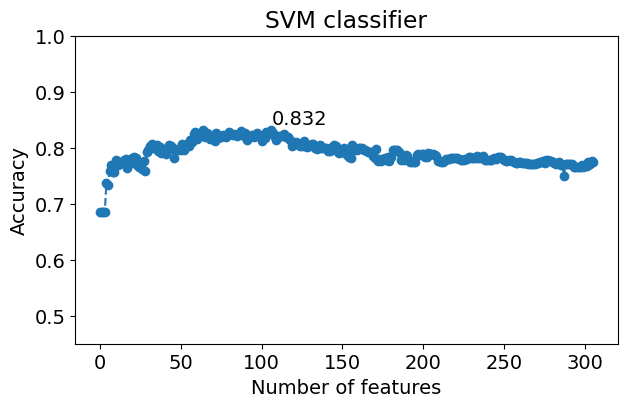

auc_best = 0.83173077
best auc (SVM) =  0.8317307692307692 Number of features =  106
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #0: 0.832 <-> 0.832
Iter #1: 0.832 <-> 0.832
Iter #2: 0.832 <-> 0.832
Iter #3: 0.832 <-> 0.832
Iter #9: 0.832 <-> 0.832
Iter #14: 0.832 <-> 0.832
Iter #19: 0.833 <-> 0.832
Iter #28: 0.833 <-> 0.832
Iter #31: 0.836 <-> 0.832
Iter #40: 0.832 <-> 0.832
Iter #41: 0.832 <-> 0.832
Iter #43: 0.833 <-> 0.832
Iter #57: 0.833 <-> 0.832
Iter #62: 0.832 <-> 0.832
Iter #65: 0.834 <-> 0.832
Iter #67: 0.833 <-> 0.832
Iter #69: 0.832 <-> 0.832
Iter #75: 0.835 <-> 0.832
Iter #78: 0.833 <-> 0.832
Iter #82: 0.833 <-> 0.832
Iter #89: 0.832 <-> 0.832
Iter #100: 0.832 <-> 0.832
Withdraw feature #31, added accracy 0.004006410256410353
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #0: 0.836 <-> 0.836
Iter #3: 0.836 <-> 0.836
Iter #5: 0.836 <-> 0.836
Iter #11: 0.839 <-> 0.836
Iter #15: 0.838 <-> 0.836
Iter #17: 0.838 <-> 0.836
Iter #21: 0.838 <-> 0.836
Iter #25: 0.837 <-> 0.836
Iter #38: 0.836 <-> 0.836
Iter #41: 0.839 <-> 0.836
Iter #43: 0.837 <-> 0.836
Iter #45: 0.836 <-> 0.836
Iter #46: 0.836 <-> 0.836
Iter #56: 0.837 <-> 0.836
Iter #63: 0.837 <-> 0.836
Iter #72: 0.841 <-> 0.836
Iter #78: 0.843 <-> 0.836
Iter #83: 0.836 <-> 0.836
Iter #85: 0.836 <-> 0.836
Iter #87: 0.837 <-> 0.836
Iter #96: 0.836 <-> 0.836
Iter #100: 0.837 <-> 0.836
Withdraw feature #78, added accracy 0.00741185897435892
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #21: 0.845 <-> 0.843
Iter #34: 0.847 <-> 0.843
Iter #35: 0.844 <-> 0.843
Iter #36: 0.844 <-> 0.843
Iter #39: 0.844 <-> 0.843
Iter #41: 0.844 <-> 0.843
Iter #56: 0.845 <-> 0.843
Iter #76: 0.843 <-> 0.843
Iter #84: 0.844 <-> 0.843
Iter #91: 0.843 <-> 0.843
Iter #94: 0.844 <-> 0.843
Withdraw feature #34, added accracy 0.003405448717948789
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #25: 0.849 <-> 0.847
Iter #35: 0.847 <-> 0.847
Iter #37: 0.847 <-> 0.847
Iter #40: 0.847 <-> 0.847
Iter #45: 0.847 <-> 0.847
Iter #46: 0.848 <-> 0.847
Iter #65: 0.847 <-> 0.847
Iter #74: 0.847 <-> 0.847
Iter #80: 0.848 <-> 0.847
Iter #90: 0.847 <-> 0.847
Iter #93: 0.847 <-> 0.847
Withdraw feature #25, added accracy 0.0024038461538460343
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #5: 0.849 <-> 0.849
Iter #11: 0.851 <-> 0.849
Iter #21: 0.851 <-> 0.849
Iter #28: 0.849 <-> 0.849
Iter #29: 0.849 <-> 0.849
Iter #30: 0.849 <-> 0.849
Iter #31: 0.849 <-> 0.849
Iter #32: 0.849 <-> 0.849
Iter #33: 0.851 <-> 0.849
Iter #36: 0.849 <-> 0.849
Iter #50: 0.851 <-> 0.849
Iter #51: 0.849 <-> 0.849
Iter #61: 0.851 <-> 0.849
Iter #62: 0.849 <-> 0.849
Iter #84: 0.849 <-> 0.849
Iter #87: 0.851 <-> 0.849
Iter #89: 0.851 <-> 0.849
Iter #92: 0.849 <-> 0.849
Iter #93: 0.851 <-> 0.849
Withdraw feature #21, added accracy 0.002203525641025772
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #27: 0.852 <-> 0.851
Iter #28: 0.852 <-> 0.851
Iter #29: 0.852 <-> 0.851
Iter #30: 0.852 <-> 0.851
Iter #31: 0.852 <-> 0.851
Iter #32: 0.852 <-> 0.851
Iter #43: 0.852 <-> 0.851
Iter #49: 0.852 <-> 0.851
Iter #72: 0.852 <-> 0.851
Iter #75: 0.852 <-> 0.851
Iter #77: 0.851 <-> 0.851
Iter #85: 0.852 <-> 0.851
Iter #86: 0.853 <-> 0.851
Withdraw feature #86, added accracy 0.0014022435897435015
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #32: 0.853 <-> 0.853
Iter #33: 0.853 <-> 0.853
Iter #35: 0.853 <-> 0.853
Iter #50: 0.853 <-> 0.853
Iter #63: 0.853 <-> 0.853
Iter #87: 0.853 <-> 0.853
Iter #90: 0.853 <-> 0.853
Iter #96: 0.856 <-> 0.853
Withdraw feature #96, added accracy 0.0030048076923077094
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #0: 0.856 <-> 0.856
Iter #27: 0.858 <-> 0.856
Iter #28: 0.858 <-> 0.856
Iter #29: 0.858 <-> 0.856
Iter #30: 0.858 <-> 0.856
Iter #31: 0.858 <-> 0.856
Iter #43: 0.856 <-> 0.856
Iter #49: 0.857 <-> 0.856
Iter #72: 0.856 <-> 0.856
Iter #75: 0.858 <-> 0.856
Iter #90: 0.859 <-> 0.856
Iter #93: 0.856 <-> 0.856
Withdraw feature #90, added accracy 0.003405448717948789
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #43: 0.860 <-> 0.859
Iter #75: 0.859 <-> 0.859
Withdraw feature #43, added accracy 0.0008012820512819374
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)
 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 14.36it/s]

UAR = 0.314


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.02it/s]

UAR = 0.329


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 14.72it/s]

UAR = 0.340


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 14.67it/s]

UAR = 0.352


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 14.91it/s]

UAR = 0.363


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 14.95it/s]

UAR = 0.373


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.92it/s]

UAR = 0.388


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.35it/s]

UAR = 0.399


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.08it/s]

UAR = 0.404


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.41it/s]

UAR = 0.415


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.75it/s]

UAR = 0.415


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.89it/s]

UAR = 0.415


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.31it/s]

UAR = 0.413


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.74it/s]

UAR = 0.415


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.77it/s]

UAR = 0.417


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.63it/s]

UAR = 0.425


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.91it/s]

UAR = 0.427


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.09it/s]

UAR = 0.426


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.88it/s]

UAR = 0.427


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.53it/s]

UAR = 0.426


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.58it/s]

UAR = 0.420


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.83it/s]

UAR = 0.421


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.65it/s]

UAR = 0.424


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.17it/s]

UAR = 0.423


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.82it/s]

UAR = 0.417


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.08it/s]

UAR = 0.418


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.37it/s]

UAR = 0.428


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 14.44it/s]

UAR = 0.426


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 13.59it/s]

UAR = 0.420


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 12.89it/s]

UAR = 0.428


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 12.05it/s]

UAR = 0.418


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 11.23it/s]

UAR = 0.417


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.31it/s]

UAR = 0.416


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.77it/s]

UAR = 0.421


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  8.95it/s]

UAR = 0.418


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  8.77it/s]

UAR = 0.415


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  7.56it/s]

UAR = 0.409


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  6.76it/s]

UAR = 0.410


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  6.91it/s]

UAR = 0.405


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


UAR = 0.403


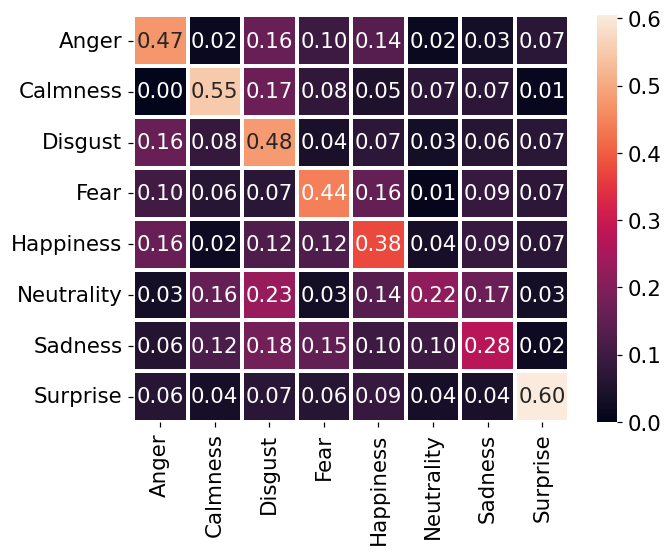

  0%|                                                                                                                                                                                              | 0/200 [00:00<?, ?it/s]

Saving confusion matrix with name:  confusion_matrix_SVM_surprised.jpg


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.424e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
  0%|▉                                                                                                                                                                                     | 1/200 [00:08<27:52,  8.40s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.424e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
  1%|█▊                                                                              

  8%|█████████████▌                                                                                                                                                                       | 15/200 [02:04<25:36,  8.30s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.424e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
  8%|██████████████▍                                                                                                                                                                      | 16/200 [02:13<25:27,  8.30s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 15%|███████████████████████████▏                                                                                                                                                         | 30/200 [04:10<23:46,  8.39s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.423e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
 16%|████████████████████████████                                                                                                                                                         | 31/200 [04:19<23:37,  8.39s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 22%|████████████████████████████████████████▋                                                                                                                                            | 45/200 [06:43<27:23, 10.60s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.406e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
 23%|█████████████████████████████████████████▋                                                                                                                                           | 46/200 [06:53<27:03, 10.54s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 30%|██████████████████████████████████████████████████████▎                                                                                                                              | 60/200 [09:23<24:43, 10.60s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.269e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
 30%|███████████████████████████████████████████████████████▏                                                                                                                             | 61/200 [09:34<24:36, 10.62s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 38%|███████████████████████████████████████████████████████████████████▉                                                                                                                 | 75/200 [12:04<22:06, 10.62s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.792e+01, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
 38%|████████████████████████████████████████████████████████████████████▊                                                                                                                | 76/200 [12:14<21:50, 10.57s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 45%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 90/200 [14:44<19:39, 10.72s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.679e+01, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
 46%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 91/200 [14:54<19:29, 10.73s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 52%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 105/200 [17:25<17:05, 10.80s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.055e+01, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
 53%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 106/200 [17:35<16:48, 10.73s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 120/200 [20:00<13:19,  9.99s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.065e+00, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 121/200 [20:09<13:02,  9.90s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 135/200 [22:20<09:58,  9.20s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.467e-02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 136/200 [22:30<09:53,  9.28s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

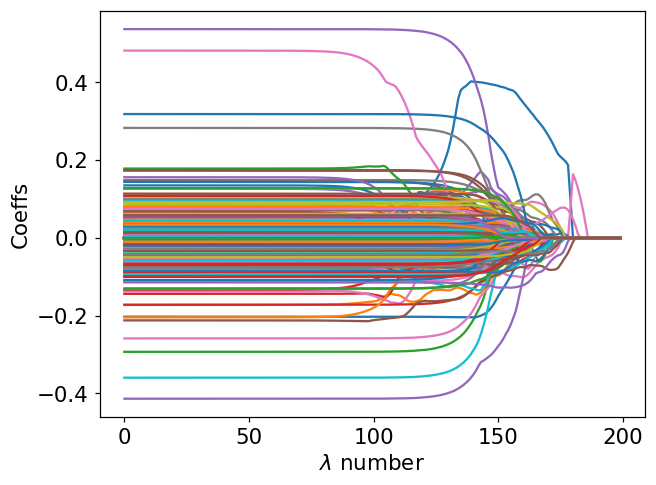

  0%|▌                                                                                                                                                                                     | 1/306 [00:00<04:48,  1.06it/s]

Iter =  1  AUC = 0.7314


  1%|█▊                                                                                                                                                                                    | 3/306 [00:02<04:44,  1.07it/s]

Iter =  3  AUC = 0.7342


  2%|███▌                                                                                                                                                                                  | 6/306 [00:05<04:47,  1.04it/s]

Iter =  6  AUC = 0.7378


  2%|████▏                                                                                                                                                                                 | 7/306 [00:06<04:31,  1.10it/s]

Iter =  7  AUC = 0.7616


  3%|█████▎                                                                                                                                                                                | 9/306 [00:09<06:19,  1.28s/it]

Iter =  9  AUC = 0.7664


  4%|███████▋                                                                                                                                                                             | 13/306 [00:14<05:45,  1.18s/it]

Iter =  13  AUC = 0.7953


  5%|████████▎                                                                                                                                                                            | 14/306 [00:16<06:44,  1.39s/it]

Iter =  14  AUC = 0.8009


  5%|████████▊                                                                                                                                                                            | 15/306 [00:18<07:36,  1.57s/it]

Iter =  15  AUC = 0.8025


  5%|█████████▍                                                                                                                                                                           | 16/306 [00:19<07:02,  1.46s/it]

Iter =  16  AUC = 0.8205


  6%|██████████                                                                                                                                                                           | 17/306 [00:21<07:54,  1.64s/it]

Iter =  17  AUC = 0.8323


  6%|██████████▋                                                                                                                                                                          | 18/306 [00:23<07:19,  1.52s/it]

Iter =  18  AUC = 0.8375


  8%|███████████████▍                                                                                                                                                                     | 26/306 [00:30<04:07,  1.13it/s]

Iter =  26  AUC = 0.8466


  9%|████████████████▌                                                                                                                                                                    | 28/306 [00:31<04:03,  1.14it/s]

Iter =  28  AUC = 0.8560


 10%|█████████████████▋                                                                                                                                                                   | 30/306 [00:33<04:03,  1.13it/s]

Iter =  30  AUC = 0.8618


 11%|███████████████████▌                                                                                                                                                                 | 33/306 [00:36<03:45,  1.21it/s]

Iter =  33  AUC = 0.8634


 19%|█████████████████████████████████▋                                                                                                                                                   | 57/306 [00:59<04:23,  1.06s/it]

Iter =  57  AUC = 0.8642


 20%|████████████████████████████████████                                                                                                                                                 | 61/306 [01:03<04:29,  1.10s/it]

Iter =  61  AUC = 0.8644


 21%|█████████████████████████████████████▊                                                                                                                                               | 64/306 [01:06<04:18,  1.07s/it]

Iter =  64  AUC = 0.8668


 21%|██████████████████████████████████████▍                                                                                                                                              | 65/306 [01:08<04:25,  1.10s/it]

Iter =  65  AUC = 0.8684


 22%|███████████████████████████████████████                                                                                                                                              | 66/306 [01:09<04:16,  1.07s/it]

Iter =  66  AUC = 0.8702


 22%|████████████████████████████████████████▏                                                                                                                                            | 68/306 [01:11<04:12,  1.06s/it]

Iter =  68  AUC = 0.8722


 24%|███████████████████████████████████████████▏                                                                                                                                         | 73/306 [01:16<04:19,  1.11s/it]

Iter =  73  AUC = 0.8724


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 306/306 [07:27<00:00,  1.46s/it]


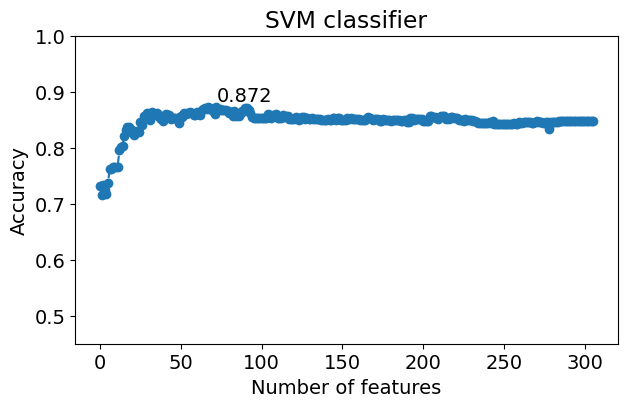

auc_best = 0.87239583
best auc (SVM) =  0.8723958333333333 Number of features =  72
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #8: 0.872 <-> 0.872
Iter #9: 0.872 <-> 0.872
Iter #10: 0.872 <-> 0.872
Iter #11: 0.872 <-> 0.872
Iter #18: 0.872 <-> 0.872
Iter #26: 0.873 <-> 0.872
Iter #31: 0.872 <-> 0.872
Iter #36: 0.875 <-> 0.872
Iter #39: 0.873 <-> 0.872
Iter #45: 0.875 <-> 0.872
Iter #47: 0.874 <-> 0.872
Iter #49: 0.874 <-> 0.872
Iter #57: 0.874 <-> 0.872
Iter #60: 0.874 <-> 0.872
Iter #62: 0.873 <-> 0.872
Withdraw feature #36, added accracy 0.0026041666666667407
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #3: 0.875 <-> 0.875
Iter #19: 0.875 <-> 0.875
Iter #29: 0.875 <-> 0.875
Iter #30: 0.875 <-> 0.875
Iter #32: 0.875 <-> 0.875
Iter #33: 0.875 <-> 0.875
Iter #34: 0.875 <-> 0.875
Iter #35: 0.875 <-> 0.875
Iter #36: 0.875 <-> 0.875
Iter #54: 0.876 <-> 0.875
Iter #57: 0.876 <-> 0.875
Withdraw feature #54, added accracy 0.0008012820512820484
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #1: 0.876 <-> 0.876
Iter #3: 0.876 <-> 0.876
Iter #6: 0.878 <-> 0.876
Iter #10: 0.877 <-> 0.876
Iter #12: 0.878 <-> 0.876
Iter #16: 0.876 <-> 0.876
Iter #28: 0.877 <-> 0.876
Iter #30: 0.877 <-> 0.876
Iter #32: 0.876 <-> 0.876
Iter #33: 0.876 <-> 0.876
Iter #34: 0.876 <-> 0.876
Iter #35: 0.876 <-> 0.876
Iter #36: 0.876 <-> 0.876
Iter #39: 0.877 <-> 0.876
Iter #43: 0.877 <-> 0.876
Iter #44: 0.876 <-> 0.876
Iter #55: 0.877 <-> 0.876
Iter #56: 0.878 <-> 0.876
Iter #67: 0.876 <-> 0.876
Withdraw feature #12, added accracy 0.0020032051282051766
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #3: 0.878 <-> 0.878
Iter #6: 0.879 <-> 0.878
Iter #13: 0.878 <-> 0.878
Iter #14: 0.878 <-> 0.878
Iter #15: 0.878 <-> 0.878
Iter #18: 0.879 <-> 0.878
Iter #29: 0.878 <-> 0.878
Iter #31: 0.878 <-> 0.878
Iter #32: 0.878 <-> 0.878
Iter #33: 0.878 <-> 0.878
Iter #34: 0.878 <-> 0.878
Iter #35: 0.878 <-> 0.878
Iter #48: 0.878 <-> 0.878
Iter #54: 0.878 <-> 0.878
Withdraw feature #6, added accracy 0.0010016025641024218
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #3: 0.879 <-> 0.879
Iter #8: 0.880 <-> 0.879
Iter #12: 0.879 <-> 0.879
Iter #17: 0.880 <-> 0.879
Iter #26: 0.879 <-> 0.879
Iter #28: 0.881 <-> 0.879
Iter #30: 0.879 <-> 0.879
Iter #31: 0.879 <-> 0.879
Iter #32: 0.879 <-> 0.879
Iter #33: 0.879 <-> 0.879
Iter #34: 0.879 <-> 0.879
Iter #37: 0.880 <-> 0.879
Iter #47: 0.880 <-> 0.879
Iter #53: 0.880 <-> 0.879
Iter #54: 0.880 <-> 0.879
Iter #56: 0.879 <-> 0.879
Iter #62: 0.880 <-> 0.879
Withdraw feature #28, added accracy 0.0020032051282052876
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #0: 0.882 <-> 0.881
Iter #1: 0.881 <-> 0.881
Iter #3: 0.881 <-> 0.881
Iter #8: 0.882 <-> 0.881
Iter #11: 0.881 <-> 0.881
Iter #12: 0.881 <-> 0.881
Iter #13: 0.882 <-> 0.881
Iter #15: 0.881 <-> 0.881
Iter #16: 0.881 <-> 0.881
Iter #18: 0.881 <-> 0.881
Iter #19: 0.881 <-> 0.881
Iter #20: 0.881 <-> 0.881
Iter #21: 0.881 <-> 0.881
Iter #22: 0.881 <-> 0.881
Iter #26: 0.881 <-> 0.881
Iter #27: 0.881 <-> 0.881
Iter #29: 0.881 <-> 0.881
Iter #30: 0.881 <-> 0.881
Iter #31: 0.881 <-> 0.881
Iter #32: 0.881 <-> 0.881
Iter #33: 0.881 <-> 0.881
Iter #46: 0.882 <-> 0.881
Iter #52: 0.882 <-> 0.881
Iter #55: 0.881 <-> 0.881
Iter #64: 0.882 <-> 0.881
Iter #67: 0.881 <-> 0.881
Withdraw feature #8, added accracy 0.0014022435897435015
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #3: 0.882 <-> 0.882
Iter #4: 0.883 <-> 0.882
Iter #10: 0.883 <-> 0.882
Iter #11: 0.883 <-> 0.882
Iter #12: 0.882 <-> 0.882
Iter #17: 0.883 <-> 0.882
Iter #18: 0.883 <-> 0.882
Iter #19: 0.883 <-> 0.882
Iter #20: 0.883 <-> 0.882
Iter #21: 0.883 <-> 0.882
Iter #28: 0.882 <-> 0.882
Iter #29: 0.882 <-> 0.882
Iter #30: 0.882 <-> 0.882
Iter #31: 0.882 <-> 0.882
Iter #32: 0.882 <-> 0.882
Iter #45: 0.882 <-> 0.882
Iter #47: 0.882 <-> 0.882
Iter #54: 0.883 <-> 0.882
Withdraw feature #4, added accracy 0.00040064102564107973
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)


Iter #1: 0.883 <-> 0.883
Iter #3: 0.883 <-> 0.883
Iter #9: 0.883 <-> 0.883
Iter #12: 0.883 <-> 0.883
Iter #44: 0.883 <-> 0.883
Withdraw feature #1, added accracy 0.0008012820512820484
NEW ROUND


/tmp/ipykernel_43645/466324840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_up = -np.ones_like(feature_ind).astype(np.float)
 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.89it/s]

UAR = 0.357


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.23it/s]

UAR = 0.365


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.44it/s]

UAR = 0.380


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.72it/s]

UAR = 0.387


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.89it/s]

UAR = 0.391


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.74it/s]

UAR = 0.395


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.11it/s]

UAR = 0.395


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.98it/s]

UAR = 0.400


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.80it/s]

UAR = 0.403


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.92it/s]

UAR = 0.408


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.31it/s]

UAR = 0.411


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.74it/s]

UAR = 0.410


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.07it/s]

UAR = 0.423


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.96it/s]

UAR = 0.414


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.98it/s]

UAR = 0.415


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 22.20it/s]

UAR = 0.414


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 21.46it/s]

UAR = 0.421


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 21.03it/s]

UAR = 0.421


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 21.06it/s]

UAR = 0.417


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 21.54it/s]

UAR = 0.426


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 21.02it/s]

UAR = 0.426


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 21.48it/s]

UAR = 0.419


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 21.34it/s]

UAR = 0.416


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 21.62it/s]

UAR = 0.419


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.16it/s]

UAR = 0.417


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.94it/s]

UAR = 0.417


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.54it/s]

UAR = 0.410


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.65it/s]

UAR = 0.412


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.16it/s]

UAR = 0.411


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.22it/s]

UAR = 0.411


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.84it/s]

UAR = 0.402


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 14.55it/s]

UAR = 0.404


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 12.57it/s]

UAR = 0.404


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 11.03it/s]

UAR = 0.400


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.30it/s]

UAR = 0.399


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  7.30it/s]

UAR = 0.391


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  7.01it/s]

UAR = 0.399


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  5.58it/s]

UAR = 0.404


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  5.39it/s]

UAR = 0.409


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.91it/s]


UAR = 0.402


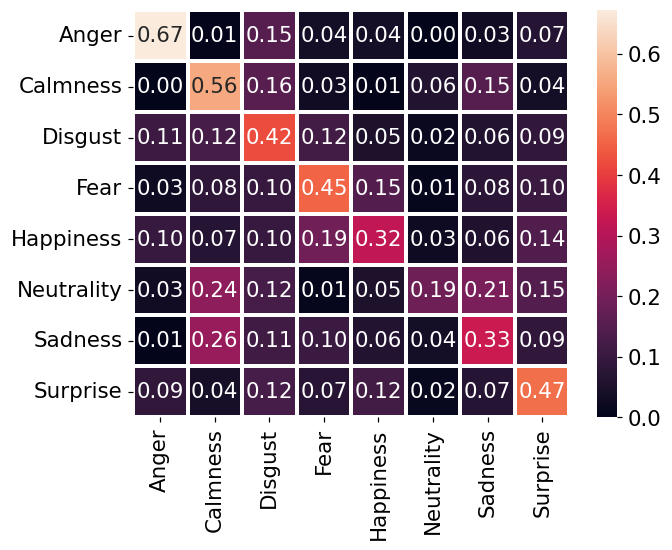

Saving confusion matrix with name:  confusion_matrix_SVM_angry.jpg


In [11]:
emotions = ['happy', 'neutral', 'sad', 'calm', 'fear', 'disgust', 'surprised', 'angry']
C = np.logspace(-3.5, -0.0, 40, endpoint=True)

for emotion_label in emotions:
    # Relabeling and normilizing
    y_true = np.zeros((len(y)))
    y_true[np.squeeze(y.values==emotion_label)] = 1
    y_true[y_true==0] = -1

    X_data = X.values
    X_norm = (X_data - X_data.mean(axis=0)) / X_data.std(axis=0)
    y_reg = copy.copy(y_true)

    # LASSO ranking
    Lasso_model = linear_model.Lasso()
    Npt = 200
    coeffs = np.zeros((X_norm.shape[1],Npt))
    lambda_ = np.logspace(-12.5, 0.3, Npt)
    i = 0
    for lamb in tqdm(lambda_):
        Lasso_model = linear_model.Lasso(alpha=lamb, max_iter=20000)
        Lasso_model.fit(X_norm,y_reg)
        coeffs[:,i] = Lasso_model.coef_
        i = i + 1

    plt.figure(dpi=110)
    plt.plot(coeffs.T)
    plt.xlabel('$\lambda$ number')
    plt.ylabel('Coeffs')
    plt.show()

    Rank_lasso = []
    for i in range(coeffs.shape[1]-1,-1,-1):
        withdraw_features = np.nonzero(coeffs[:,i])[0];
        something_new = np.setdiff1d(withdraw_features, Rank_lasso)
        if len(something_new):
            for ii in range(len(something_new)):
                Rank_lasso.append(something_new[ii])
    
    np.save(f'../../data/svm/Lasso_Ranking_SVM_{emotion_label}_result.npy', Rank_lasso)    # .npy extension is added if not given
    Rank_lasso = np.load(f'../../data/svm/Lasso_Ranking_SVM_{emotion_label}_result.npy')

    # LOSO accuracy estimation
    Rank = Rank_lasso
    auc_svm = []
    auc_best = 0
    ind_best = 0
    for k in tqdm(range(1,len(Rank)+1)):
        feature_inds = Rank[:k]
        auc = SVM_eval(X_norm,y_reg, feature_inds, ID)    
        auc_svm.append(auc)
        if (auc>auc_best):
            auc_best = auc
            ind_best = k-1
            print('Iter = ', k, f' AUC = {auc:.4f}' )
    
    fig,ax=plt.subplots(figsize=(7,4),dpi=100)
    plt.rcParams.update({'font.size': 14})
    plt.plot(auc_svm,marker='o', linestyle='dashed')
    plt.text(ind_best, auc_best+0.01, f'{auc_best:.3f}')
    plt.xlabel('Number of features')
    plt.ylabel('Accuracy')
    plt.title('SVM classifier')
    plt.ylim([0.45, 1.00])
    plt.show()
    
    print(f'auc_best = {auc_best:.8f}')
    print('best auc (SVM) = ', np.max(auc_svm), 'Number of features = ', np.argmax(auc_svm))

    # Backward step selection
    ind_best = np.argmax(auc_svm)
    [acc_final,feature_ind] = back_step_selection_loso(X_norm, y_reg, Rank[:ind_best+1],ID)
    np.save(f'../../data/svm/feature_SVM_idx_{emotion_label}.npy', feature_ind)    # .npy extension is added if not given
    feature_ind = np.load(f'../../data/svm/feature_SVM_idx_{emotion_label}.npy')

    # 5-fold CV (selected feature space)
    group_members= data_loader.get_k_fold_group_member()
    X_new = pd.DataFrame(X_norm[:,feature_ind])
    X_k_folds, y_k_folds = data_loader.get_custom_k_folds(X_new, y, ID, group_members)
    
    UAR_list = []
    UAR_best = 0
    for val_C in C:
        model = SVC(kernel = 'linear', C=val_C)
        UAR,y_pr,y_tr,y_te = model_training.estimate_model(model, X_k_folds, y_k_folds)
        if UAR_best<UAR:
            UAR_best,y_pred,y_true,y_test = UAR,y_pr,y_tr,y_te
            C_best = val_C
        UAR_list.append(UAR)
    plotting_utils.plot_confusion_matrix_eng(y_test, y_true, y_pred,image_path=f'confusion_matrix_SVM_{emotion_label}.jpg')

# 5-fold CV (full feature space)

In [12]:
group_members= data_loader.get_k_fold_group_member()
X_new = pd.DataFrame(X_norm)
X_k_folds, y_k_folds = data_loader.get_custom_k_folds(X_new, y, ID, group_members)

 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  7.57it/s]

UAR = 0.391


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  8.13it/s]

UAR = 0.419


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  8.92it/s]

UAR = 0.419


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.40it/s]

UAR = 0.436


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.61it/s]

UAR = 0.456


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.84it/s]

UAR = 0.454


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.72it/s]

UAR = 0.444


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.16it/s]

UAR = 0.436


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  8.86it/s]

UAR = 0.429


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.10it/s]


UAR = 0.423
UAR_best = 0.456, C_best = 0.004


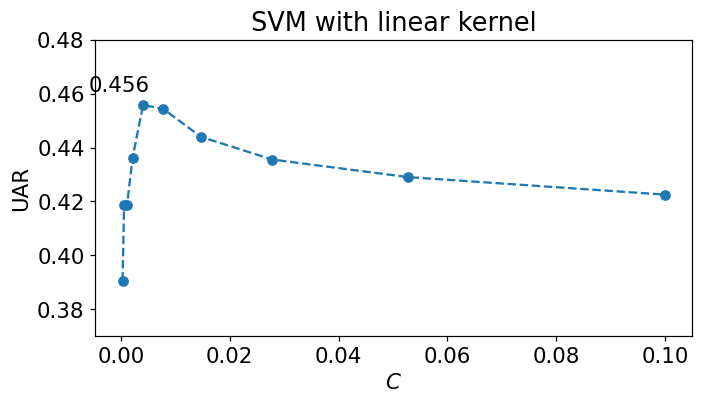

In [13]:
C = np.logspace(-3.5, -1.0, 10, endpoint=True)
UAR_list = []
UAR_best = 0
for val_C in C:
    model = SVC(kernel = 'linear', C=val_C)
    UAR,y_pr,y_tr,y_te = model_training.estimate_model(model, X_k_folds, y_k_folds)
    if UAR_best<UAR:
        UAR_best,y_pred,y_true,y_test = UAR,y_pr,y_tr,y_te
        C_best = val_C
    UAR_list.append(UAR)
    
    
fig,ax=plt.subplots(figsize=(7,3.5), dpi=110) # 
plt.rcParams.update({'font.size': 14})
plt.plot(C,UAR_list, marker='o', linestyle='dashed',)
# plt.semilogx(C,UAR_list, marker='o', linestyle='dashed',)
plt.ylim([0.37, 0.48])
# plt.xlabel('$\log_{10}(C)$')
plt.xlabel('$C$')
plt.ylabel('UAR')
plt.text(C_best-0.010, UAR_best+0.005, f'{UAR_best:.3f}')
plt.title('SVM with linear kernel')
print(f'UAR_best = {UAR_best:.3f}, C_best = {C_best:.3f}')    

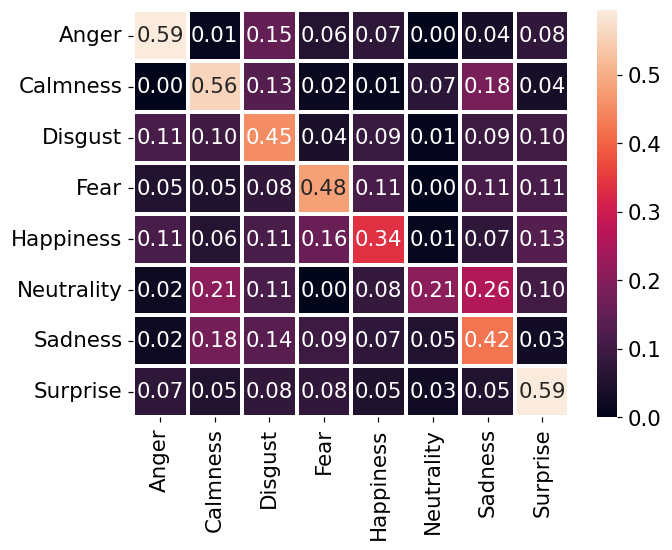

Saving confusion matrix with name:  confusion_matrix_SVM_full.jpg


In [14]:
# Confusion matrix
plotting_utils.plot_confusion_matrix_eng(y_test, y_true, y_pred,image_path=f'confusion_matrix_SVM_full.jpg')

# Joint subset of features

In [15]:
emotions = ['happy', 'neutral', 'sad', 'calm', 'fear', 'disgust', 'surprised', 'angry']
feature_joint_inds = []

for emotion_label in emotions:
    feature_ind = np.load(f'../../data/svm/feature_SVM_idx_{emotion_label}.npy')
    feature_joint_inds = np.unique(np.concatenate((feature_joint_inds, feature_ind)))

feature_joint_inds = feature_joint_inds.astype(int)

In [16]:
group_members= data_loader.get_k_fold_group_member()
X_new = pd.DataFrame(X_norm[:,feature_joint_inds])
X_k_folds, y_k_folds = data_loader.get_custom_k_folds(X_new, y, ID, group_members)

In [21]:
X_new.shape

(1440, 208)

In [19]:
C = np.logspace(-3.5, -1.0, 10, endpoint=True)
UAR_list = []
UAR_best = 0
for val_C in C:
    model = SVC(kernel = 'linear', C=val_C)
    UAR,y_pr,y_tr,y_te = model_training.estimate_model(model, X_k_folds, y_k_folds)
    if UAR_best<UAR:
        UAR_best,y_pred,y_true,y_test = UAR,y_pr,y_tr,y_te
        C_best = val_C
    UAR_list.append(UAR)
print(f'UAR_best = {UAR_best:.3f}, C_best = {C_best:.3f}')        

 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 10.86it/s]

UAR = 0.410


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 10.81it/s]

UAR = 0.425


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 12.21it/s]

UAR = 0.434


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 12.86it/s]

UAR = 0.447


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 13.21it/s]

UAR = 0.466


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 13.43it/s]

UAR = 0.473


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 13.42it/s]

UAR = 0.449


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 13.02it/s]

UAR = 0.450


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 12.10it/s]

UAR = 0.437


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.94it/s]

UAR = 0.443
UAR_best = 0.473, C_best = 0.008


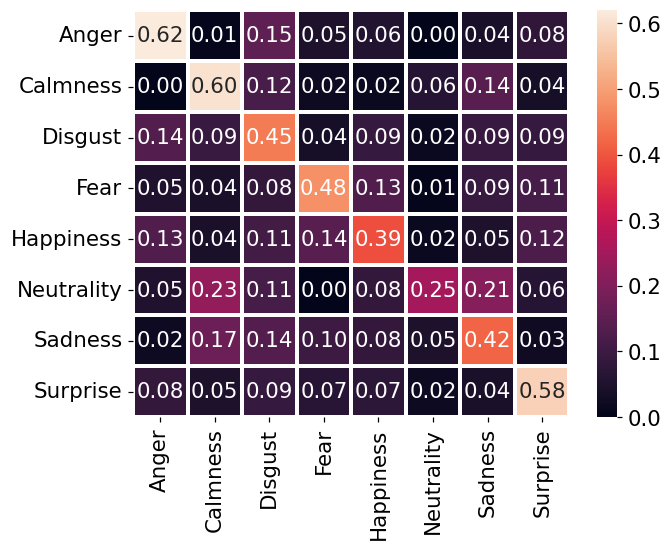

Saving confusion matrix with name:  confusion_matrix_SVM_joint_features.jpg


In [20]:
plotting_utils.plot_confusion_matrix_eng(y_test, y_true, y_pred,image_path=f'confusion_matrix_SVM_joint_features.jpg')